In [31]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import solve_ivp
import networkx as nx
import matplotlib as mpl
import matplotlib.cm as cm
from itertools import product
from matplotlib.lines import Line2D
import random
import scipy.stats as stats
from tqdm import tqdm
from scipy import interpolate
from scipy import integrate
from scipy.interpolate import interp1d
import pandas as pd
from scipy.integrate import simps
from scipy.integrate import simpson
from scipy.optimize import curve_fit

In [2]:
# build matrix containing information about all the interactions on the network, including weights
# A is the full communication tensor Na No x Na No in dimension
def build_A(Na, No, alpha, beta, gamma, delta, Ao, Aa):
    return np.kron(np.eye(Na), alpha * np.eye(No) + beta * Ao) + np.kron(Aa, gamma * np.eye(No) + delta * Ao)

def u_gauss(mu, dev, Na):
    u = np.zeros(Na)

    x = 0
    i = 0

    while i < Na:
        x = np.random.normal(mu, dev)
        if x > 0:
            u[i] = x
            i = i + 1
        else:
            i = i

    print(u)
    return u


# function for creating a vector with only positive u and with mean = mu of the gaussian:
def u_gauss2(mu, dev, Na):
    u = np.zeros(Na)

    x = 0
    i = 0
    while i < Na:
        x = np.random.normal(mu, dev)
        if x > 0:
            u[i] = x
            i = i + 1
        else:
            i = i

    mean_diff = np.mean(u) - mu
    u = u - mean_diff

    if np.all(u > 0):
        return u

    return u_gauss2(mu, dev, Na)

def plot_agent_label(Tmin, Tmax, zs, Na, No):
    t = np.linspace(Tmin,Tmax,Tmax) # start, stop, number of samples
    z = zs.sol(t) 
    
    idxs = No*np.array(range(Na))
    
    for i in range(No):
        plt.figure(i)
        option_ind = idxs + i*np.ones(Na)
        plt.plot(t,z.T[:,option_ind.astype(int)])
        plt.title('Option ' + str(i+1))
        plt.xlabel('t')
        plt.ylabel('z_ij')
        labels = []
        for j in range(Na):
            labels.append('Agent' + str(j+1))
        plt.legend(labels)
        
# plot of the focus on 1 single plot
def plot_agent_tot(zs1, zs2, Na):

    for i in range(Na):
        plt.plot(zs1, zs2[i], label=f'Agent {i+1}')

    plt.xlabel('t')
    plt.ylabel('task 2 <------ a_i ------> task 1')
    plt.title('Focus of the agents')
    if Na < 11:
        plt.legend()
        plt.show()
    else:
        plt.show()

In [3]:
def f_64(t):
    return np.array(t).astype(np.float64)

def zdot_net1(t, z, Na, No, d, A, u1, u2, b):
    # Return an Error if Na and No don't match the dimensions of z
    if Na * No != len(z):
        return "Na, No must match dimensions of z"

    # Define same-option and inter-option saturation functions
    def S1(z):
        return np.tanh(z)

    # assemble intra-agent matrix (1)
    z = f_64(z)
    A = f_64(A)
    
    inds = np.kron(np.ones((Na, Na)), np.eye(No)) > 0
    A_SO = np.zeros((Na * No, Na * No))
    A_SO = f_64(A_SO)
    A_SO[inds] = A[inds]
    A_SO = A_SO   
    
    # assemble same-option interactions and bias (2)
    F = (np.dot(A_SO, z))
    #F = F / Na

    F2 = np.zeros_like(F)
    F2 = f_64(F2)
    # assemble inter-option interactions about option j (3)
    for j in range(No):
        A_j = np.zeros((Na * No, Na * No))
        ind_mat = np.zeros((No, No))
        ind_mat[:, j] = np.ones(No)
        ind_mat[j, j] = 0
        ind_mat2 = np.kron(np.ones((Na, Na)), ind_mat)
        A_j[ind_mat2 > 0] = A[ind_mat2 > 0]
        F2 += np.dot(A_j, z)
    #F2 = F2 / Na

    F = F + F2
    F = F / Na
    #F = - d * z + S1(u1 * F + b)
    F = - d * z + S1(np.multiply(u1, F) + b)
    F = F*( 1.0/tau)

    # variation of state vector z respect time
    #proj = np.eye(Na * No)
    #dz = np.dot(proj, F)
    dz = F
    #print(t, F)
    return dz

def sim_net1(z, T, Na, No, d, A, u1, u2, rate, percent, value, times):
    
    b = []
    
    Tt = T - 200
    nb = int(rate*Tt) #nb of task switches
    
    #definition of the biases:
    for i in range(nb + 1):
        
        if i == 0:
            b_i = np.zeros(Na*No) * bias_w
        elif i != 0 and i % 2 != 0:
            b_i = generate_bias_vector_m(Na, No, percent, value, even=True) * bias_w
        elif i != 0 and i % 2 == 0:
            b_i = generate_bias_vector_m(Na, No, percent, value, even=False) * bias_w
        
        b.append(b_i)
    
    def f(t, z):
    
        if t != T:
            fi, se = find_indices_between_elements(times, t)
            return zdot_net1(t, z, Na, No, d, A, u1, u2, b[fi])
            
        if t == T:
            fi, se = find_indices_between_elements(times, t)
            return zdot_net1(t, z, Na, No, d, A, u1, u2, b[fi-1])
    
    zs = solve_ivp(f, [0, T], z, dense_output=False, t_eval=np.linspace(0, T, 200), max_step=1000, method="Radau")
    #zs = solve_ivp(f, [0, T], z, dense_output=False, t_eval=np.linspace(0, T, 200), max_step=1000, method="Radau", atol=1e-8, rtol=1e-8)
    
    return zs

In [4]:
#generate bias vector with tot percent of people with value != 0 on both task:
def generate_bias_vector_m(Na, No, percent, value, even=True):
    
    num_ones = int(Na * percent / 100)
    
    
    bias_vector = np.zeros(Na * No)
    
    
    indices = np.arange(Na * No)
    indicesminus = np.arange(Na * No)
    if even:
        indices = indices[indices % 2 == 0]  
        indicesminus = indicesminus[indicesminus % 2 != 0]
    else:
        indices = indices[indices % 2 != 0]  
        indicesminus = indicesminus[indicesminus % 2 == 0]
    
    bias_vector[indices[:num_ones]] = value
    bias_vector[indicesminus[:num_ones]] = -value
    
    return bias_vector

#funzione per trovare time window corretta
def find_indices_between_elements(arr, t):
    # Inizializza gli indici a None
    first_index = None
    second_index = None

    for i, element in enumerate(arr):
        if element <= t:
            # Trova l'indice più vicino a t
            first_index = i
        else:
            # L'elemento successivo è maggiore di t, quindi usciamo dal ciclo
            break

    if first_index is not None:
        # Calcola l'indice successivo a first_index
        second_index = first_index + 1

    return first_index, second_index

#funzione per creare vettore thresholds recolari
def find_thresh(T, rate):
    
    times = [0.0, 200.0]
    Tt = T - 200
    
    nb = int(rate*Tt) #nb of task switches
        
    #regular time interval:
    t_int = Tt / nb
    
    t_i = 200.0
    for j in range(nb):
        t_i += t_int
        times.append(t_i)
    
    return times

#funzione per creare vettore thresholds con t poissoniani
def find_thresh_p(T, rate):
    
    time_thresh = [0.0, 200.0]
    
    Tt = T - 200
    nb = int(rate*Tt) 
    
    # Poisson process for bias time intervals
    t = 200.0
    while t < T:
        t += np.random.exponential(1.0/rate)  # Generate time intervals according to Poisson process
        if t <= T:
            time_thresh.append(t)
    
    if len(time_thresh)-1 == nb:
        return time_thresh
    else:
        return find_thresh_p(T, rate)

# function to pass from a vector Na*No to a vector of Na
def new_zs(zs, Na, No):
    n2 = zs.shape[1]
    zsn = np.zeros((Na, n2))
    j = i = 0
    for i in range(0, Na * No, 2):
        zsn[j] = (zs[i] - zs[i + 1]) / 2.0
        j = j + 1

    return zsn

In [34]:
def performance(x, y, x_min, x_max, sopra_zero=True):
    """
    Calcola l'area sopra o sotto la curva dati una lista di punti (x, y) nell'intervallo [x_min, x_max] utilizzando la regola di Simpson.
    
    :param x: Lista dei punti x
    :param y: Lista dei punti y (valori della funzione)
    :param x_min: Limite inferiore dell'intervallo
    :param x_max: Limite superiore dell'intervallo
    :param sopra_zero: Se True, calcola l'area sopra y=0, altrimenti calcola l'area sotto y=0.
    :return: L'area sopra o sotto la curva nell'intervallo specificato rispetto a y=0.
    """
    if len(x) != len(y):
        raise ValueError("Le liste x e y devono avere la stessa lunghezza")
    
    # Trova gli indici in cui x è all'interno dell'intervallo [x_min, x_max]
    mask = (x >= x_min) & (x <= x_max)
    x_interval = x[mask]
    y_interval = y[mask]
    
    if sopra_zero:
        y_interval = np.maximum(y_interval, 0)
    else:
        y_interval = np.minimum(y_interval, 0)
    
    return simps(y_interval, x_interval)

def performance_2(x, y, x_min, x_max, sopra_zero=True):
    """
    Calcola l'area sopra o sotto la curva dati una lista di punti (x, y) nell'intervallo [x_min, x_max] utilizzando la regola di Simpson.
    
    :param x: Lista dei punti x
    :param y: Lista dei punti y (valori della funzione)
    :param x_min: Limite inferiore dell'intervallo
    :param x_max: Limite superiore dell'intervallo
    :param sopra_zero: Se True, calcola l'area sopra y=0, altrimenti calcola l'area sotto y=0.
    :return: L'area sopra o sotto la curva nell'intervallo specificato rispetto a y=0.
    """
    if len(x) != len(y):
        raise ValueError("Le liste x e y devono avere la stessa lunghezza")
    
    # Trova gli indici in cui x è all'interno dell'intervallo [x_min, x_max]
    mask = (x >= x_min) & (x <= x_max)
    x_interval = x[mask]
    y_interval = y[mask]
    
    if sopra_zero:
        y_interval = np.maximum(y_interval, 0)
    else:
        y_interval = np.minimum(y_interval, 0)
    
    return simpson(y_interval, x_interval, method="simpson38")

def performance_plt(x, y, x_min, x_max, sopra_zero=True):
    """
    Calcola l'area sopra o sotto la curva dati una lista di punti (x, y) nell'intervallo [x_min, x_max] utilizzando la regola di Simpson e visualizza il grafico con l'area colorata.
    
    :param x: Lista dei punti x
    :param y: Lista dei punti y (valori della funzione)
    :param x_min: Limite inferiore dell'intervallo
    :param x_max: Limite superiore dell'intervallo
    :param sopra_zero: Se True, calcola l'area sopra y=0, altrimenti calcola l'area sotto y=0.
    :return: L'area sopra o sotto la curva nell'intervallo specificato rispetto a y=0.
    """
    if len(x) != len(y):
        raise ValueError("Le liste x e y devono avere la stessa lunghezza")
    
    # Trova gli indici in cui x è all'interno dell'intervallo [x_min, x_max]
    mask = (x >= x_min) & (x <= x_max)
    x_interval = x[mask]
    y_interval = y[mask]
    
    if sopra_zero:
        y_interval = np.maximum(y_interval, 0)
    else:
        y_interval = np.minimum(y_interval, 0)
    
    area = simps(y_interval, x_interval)
    
    # Disegna il grafico
    plt.figure()
    plt.plot(x, y, label='Funzione')
    plt.fill_between(x_interval, y_interval, alpha=0.3, color='blue', label='Area sotto la curva')
    plt.axhline(0, color='black', linestyle='dashed', linewidth=1)
    plt.axvline(x_min, color='red', linestyle='dashed', linewidth=1)
    plt.axvline(x_max, color='red', linestyle='dashed', linewidth=1)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return area

In [6]:
def hom(mu, pe, times):
    # simulation
    u = mu
    A = build_A(Na, No, alpha, beta, gamma, delta, Ao, Aa)
    z = z1
    zs = sim_net1(z, T, Na, No, d, A, u, ue, rate, percent, value, times)
    zs.y = new_zs(zs.y, Na, No)

    # metric 1
    Ar = A1 = A11 = At = Att = Aw = Atot = 0

    for i in range(0, Na):
        At = Att = 0
        for j in range(1, len(times)-1):
            if j % 2 != 0:
                A1 = performance(zs.t, zs.y[i], x_min=times[j], x_max=times[j+1], sopra_zero=True)
            else:
                A1 = abs(performance(zs.t, zs.y[i], x_min=times[j], x_max=times[j+1], sopra_zero=False))
       
            At += A1
        Ar += At
        #print(i, Ar)
        
        for k in range(1, len(times)-1):
            if k % 2 != 0:
                A11 = abs(performance(zs.t, zs.y[i], x_min=times[k], x_max=times[k+1], sopra_zero=False))
            else:
                A11 = performance(zs.t, zs.y[i], x_min=times[k], x_max=times[k+1], sopra_zero=True)
            
            Att += A11
        Aw += Att
        #print(i, Aw)

    Atot = Ar - (Aw * pe)
    #print('Atot = ', Atot)

    return Atot


def hom_i(mu, pe, times, i):
    # simulation
    u = mu
    A = build_A(Na, No, alpha, beta, gamma, delta, Ao, Aa)
    z = z1
    zs = sim_net1(z, T, Na, No, d, A, u, ue, rate, percent, value, times)
    zs.y = new_zs(zs.y, Na, No)

    # metric 1
    Ar = A1 = A11 = At = Att = Aw = Atot = 0

    #for i in range(0, Na):
    At = Att = 0
    for j in range(1, len(times)-1):
        if j % 2 != 0:
            A1 = performance(zs.t, zs.y[i], x_min=times[j], x_max=times[j+1], sopra_zero=True)
        else:
            A1 = abs(performance(zs.t, zs.y[i], x_min=times[j], x_max=times[j+1], sopra_zero=False))

        At += A1
    Ar += At
    #print(i, Ar)

    for k in range(1, len(times)-1):
        if k % 2 != 0:
            A11 = abs(performance(zs.t, zs.y[i], x_min=times[k], x_max=times[k+1], sopra_zero=False))
        else:
            A11 = performance(zs.t, zs.y[i], x_min=times[k], x_max=times[k+1], sopra_zero=True)

        Att += A11
    Aw += Att
    #print(i, Aw)

    Atot = Ar - (Aw * pe)
    #print('Atot = ', Atot)

    return Atot

In [7]:
# model similar to anastasia's one (old functions) 

def zdot_net1_old(t, z, Na, No, d, A, u1, u2, b):
    # Return an Error if Na and No don't match the dimensions of z
    if Na * No != len(z):
        return "Na, No must match dimensions of z"

    # Define same-option and inter-option saturation functions
    def S1(z):
        return np.tanh(z)

    # assemble intra-agent matrix (1)
    inds = np.kron(np.ones((Na, Na)), np.eye(No)) > 0
    A_SO = np.zeros((Na * No, Na * No))
    A_SO[inds] = A[inds]
    A_SO = A_SO

    # assemble same-option interactions and bias (2)
    F = (np.dot(A_SO, z))
    #F = F / Na

    F2 = np.zeros_like(F)
    # assemble inter-option interactions about option j (3)
    for j in range(No):
        A_j = np.zeros((Na * No, Na * No))
        ind_mat = np.zeros((No, No))
        ind_mat[:, j] = np.ones(No)
        ind_mat[j, j] = 0
        ind_mat2 = np.kron(np.ones((Na, Na)), ind_mat)
        A_j[ind_mat2 > 0] = A[ind_mat2 > 0]
        F2 += np.dot(A_j, z)
    #F2 = F2 / Na

    F = F + F2
    F = F / Na
    F = - d * z + S1(np.multiply(u1, F) + b)
    F = F *(1.0/tau)

    # variation of state vector z respect time
    proj = np.eye(Na * No)
    dz = np.dot(proj, F)
    return dz

#funzione con biases a t regolari

def sim_net1_old(z, T, Na, No, d, A, u1, u2, rate, percent, value, times):
    
    b = []
    
    Tt = T - 200
    nb = int(rate*Tt) #nb of task switches
    
    #definition of the biases:
    for i in range(nb + 1):
        
        if i == 0:
            b_i = np.zeros(Na*No) * bias_w
        elif i != 0 and i % 2 != 0:
            b_i = generate_bias_vector_m(Na, No, percent, value, even=True) * bias_w
        elif i != 0 and i % 2 == 0:
            b_i = generate_bias_vector_m(Na, No, percent, value, even=False) * bias_w
        
        b.append(b_i)
    
    def f(t, z):
    
        if t != T:
            fi, se = find_indices_between_elements(times, t)
            return zdot_net1(t, z, Na, No, d, A, u1, u2, b[fi])
            
        if t == T:
            fi, se = find_indices_between_elements(times, t)
            return zdot_net1(t, z, Na, No, d, A, u1, u2, b[fi-1])
            
    zs = solve_ivp(f, [0, T], z, dense_output=True, t_eval=np.linspace(0, T, 1000), max_step=10000)

    return zs

#performance on the aerea old function
def performance_old(x, y, x_min, x_max, sopra_zero=True):
    x = np.array(x)
    y = np.array(y)

    tck = interpolate.splrep(x, y, k=4)  # Calcola i coefficienti dell'interpolazione
    interpolante = interpolate.splev(x, tck)  # Valuta l'interpolante nei punti x

    # Limita l'intervallo di calcolo all'intervallo desiderato
    mask = np.logical_and(x >= x_min, x <= x_max)
    x_intervallo = x[mask]
    y_intervallo = y[mask]

    # Seleziona i punti nell'intervallo desiderato sopra o sotto lo zero
    if sopra_zero:
        mask = np.logical_and(y_intervallo >= 0, x_intervallo <= x_max)
    else:
        mask = np.logical_and(y_intervallo <= 0, x_intervallo <= x_max)

    x_selezionati = x_intervallo[mask]
    y_selezionati = y_intervallo[mask]

    # Check if there are points in the selected interval
    if len(x_selezionati) == 0:
        return 0

    area, errore = integrate.quad(lambda x: interpolate.splev(x, tck), x_selezionati[0], x_selezionati[-1], limit=150)
    return area

In [8]:
#another form for the function to calculate the performance but it seems not precise enough

def performance_Th(x, y, x_min, x_max, sopra_zero=True):
    x = np.array(x)
    y = np.array(y)

    # Limita l'intervallo di calcolo all'intervallo desiderato
    mask = np.logical_and(x >= x_min, x <= x_max)
    x = x[mask]
    y = y[mask]
    
    if sopra_zero:
        y = 1 * y
    else:
        y = -1 * y

    # Check if there are points in the selected interval
    if len(x) == 0:
        return 0
    
    area = np.mean(y)
    #area, errore = integrate.quad(lambda x: interpolate.splev(x, tck), x_selezionati[0], x_selezionati[-1], limit=150)
    return area

def hom_Th(mu, pe, times):
    # simulation
    u = mu
    A = build_A(Na, No, alpha, beta, gamma, delta, Ao, Aa)
    z = z1
    zs = sim_net1(z, T, Na, No, d, A, u, ue, rate, percent, value, times)
    zs.y = new_zs(zs.y, Na, No)
    
    tot = 0
    for i in range(0, Na):
        
        for j in range(1, len(times)-1):
            if j % 2 != 0:
                tot += performance(zs.t, zs.y[i], x_min=times[j], x_max=times[j+1], sopra_zero=True)
            else:
                tot += performance(zs.t, zs.y[i], x_min=times[j], x_max=times[j+1], sopra_zero=False)

    return tot

def hom_i_Th(mu, pe, times, i):
    # simulation
    u = mu
    A = build_A(Na, No, alpha, beta, gamma, delta, Ao, Aa)
    z = z1
    zs = sim_net1(z, T, Na, No, d, A, u, ue, rate, percent, value, times)
    zs.y = new_zs(zs.y, Na, No)
    
    tot = 0
    
        
    for j in range(1, len(times)-1):
        if j % 2 != 0:
            tot += performance(zs.t, zs.y[i], x_min=times[j], x_max=times[j+1], sopra_zero=True)
        else:
            tot += performance(zs.t, zs.y[i], x_min=times[j], x_max=times[j+1], sopra_zero=False)

    return tot

## Individual Optimal u

In [9]:
# case 1 agents:

Na = 1  # number of agents
No = 2  # number of tasks

#null initial conditions
z0 = np.zeros(Na*No)
#z0 = np.random.randn(Na * No) * 0.0 

z = z0
z1 = z0

# simulation run time
T = 2200

Tmin = 0
Tmax = 2200

# model parameters
d = 0.2
alpha = 0.02
beta = 0.01
gamma = 0.02
delta = 0.0
tau = 10
ue = 1

# Matrices
Ao = np.array([[1, -1], [-1, 1]])  # incongruent stimuli
Aa = np.array([0]) 
#Aa = np.array([[0, 1, 1, 1], [1, 0, 1, 1], [1, 1, 0, 1], [1, 1, 1, 0]])  # only positive interaction and all agents connetcted

In [10]:
# build A
A = build_A(Na, No, alpha, beta, gamma, delta, Ao, Aa)

In [11]:
#Biases
bias_w = 0.1
value = 1
percent = 100

##### example

In [12]:
rate = 0.002
T= 2200
times = find_thresh(T, rate)
u = 4.0
A = build_A(Na, No, alpha, beta, gamma, delta, Ao, Aa)
z = z1

In [27]:
zs = sim_net1(z, T, Na, No, d, A, u, ue, rate, percent, value, times)
#zs.y = new_zs(zs.y, Na, No)
sol = zs

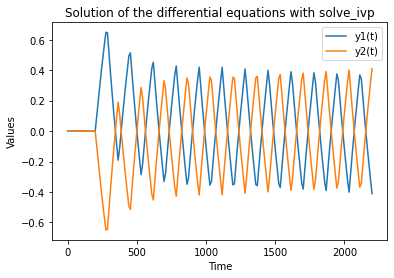

In [28]:
plt.plot(sol.t, sol.y[0], label='y1(t)')
plt.plot(sol.t, sol.y[1], label='y2(t)')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.title('Solution of the differential equations with solve_ivp')
plt.show()

##### analysis

In [12]:
us = np.linespace(0.1, 8.0, 40)
us

array([0.1       , 0.3025641 , 0.50512821, 0.70769231, 0.91025641,
       1.11282051, 1.31538462, 1.51794872, 1.72051282, 1.92307692,
       2.12564103, 2.32820513, 2.53076923, 2.73333333, 2.93589744,
       3.13846154, 3.34102564, 3.54358974, 3.74615385, 3.94871795,
       4.15128205, 4.35384615, 4.55641026, 4.75897436, 4.96153846,
       5.16410256, 5.36666667, 5.56923077, 5.77179487, 5.97435897,
       6.17692308, 6.37948718, 6.58205128, 6.78461538, 6.98717949,
       7.18974359, 7.39230769, 7.59487179, 7.7974359 , 8.        ])

In [13]:
u_opt = []
A_value = []

In [14]:
rates = [0.002, 0.003, 0.004, 0.005, 0.006, 0.007]
T = 2200

In [15]:
def opt_individual(T, times):
    best_A = 0
    best_u = 0
    pe = 1.0

    for u in us:
        Area = hom(u, pe, times)
        if Area > best_A:
            best_A = Area
            best_u = u
        
    u_opt.append(best_u)
    A_value.append(best_A)

    print("Rate:", rate)
    print("Best u parameter:", best_u)
    print("Best performance value:", best_A)

In [16]:
for rate in tqdm(rates):
    times = find_thresh(T, rate)
    opt_individual(T, times)

 17%|█▋        | 1/6 [00:06<00:32,  6.50s/it]

Rate: 0.002
Best u parameter: 3.948717948717949
Best performance value: 1552.0008623201832


 33%|███▎      | 2/6 [00:14<00:27,  6.99s/it]

Rate: 0.003
Best u parameter: 2.935897435897436
Best performance value: 962.7659849655965


 50%|█████     | 3/6 [00:23<00:22,  7.66s/it]

Rate: 0.004
Best u parameter: 2.1256410256410256
Best performance value: 707.6641550043141


 67%|██████▋   | 4/6 [00:34<00:17,  8.59s/it]

Rate: 0.005
Best u parameter: 1.3153846153846156
Best performance value: 555.0884789558368


 83%|████████▎ | 5/6 [00:47<00:09,  9.81s/it]

Rate: 0.006
Best u parameter: 0.5051282051282051
Best performance value: 455.4538824142685


100%|██████████| 6/6 [01:01<00:00, 10.20s/it]

Rate: 0.007
Best u parameter: 0.1
Best performance value: 393.1945179795785


In [17]:
u_opt

[3.948717948717949,
 2.935897435897436,
 2.1256410256410256,
 1.3153846153846156,
 0.5051282051282051,
 0.1]

In [22]:
# 4 n switch
T = 2200
rate = 0.002

times = find_thresh(T, rate)

In [27]:
best_A = 0
best_u = 0
pe = 1.0

for u in tqdm(us):
    #print('u = ', u)
    Area = hom(u, pe, times)
    if Area > best_A:
        best_A = Area
        best_u = u
        
u_opt.append(best_u)
A_value.append(best_A)

print("Best u parameter:", best_u)
print("Best performance value:", best_A)

100%|██████████| 40/40 [00:38<00:00,  1.04it/s]

Best u parameter: 0.1
Best performance value: 393.1945179795785


In [28]:
u_opt

[3.8692307692307693,
 2.98974358974359,
 2.235897435897436,
 1.3564102564102565,
 0.6025641025641025,
 0.1]

In [29]:
nb_sw = [4,6,8,10,12,14]
nb_biases = [1,1,1,1,1,1]

In [30]:
# Creazione del dataframe utilizzando le liste di dati
data = {'nb_biases': nb_biases,'nb_sw': nb_sw, 'optimal_u': u_opt, 'Best_performance': A_value }
df = pd.DataFrame(data)

# Salvataggio del dataframe in un file CSV
df.to_csv('./u_opt_hom_4_to_14_Individual_new.csv', index=False)

##### plot performance

5.460178651603513
5.51738313557962
5.149808841856242
5.149808841856242
0.5405967783475998
0.5406251236278218
0.5406251236278218


<Figure size 720x432 with 0 Axes>

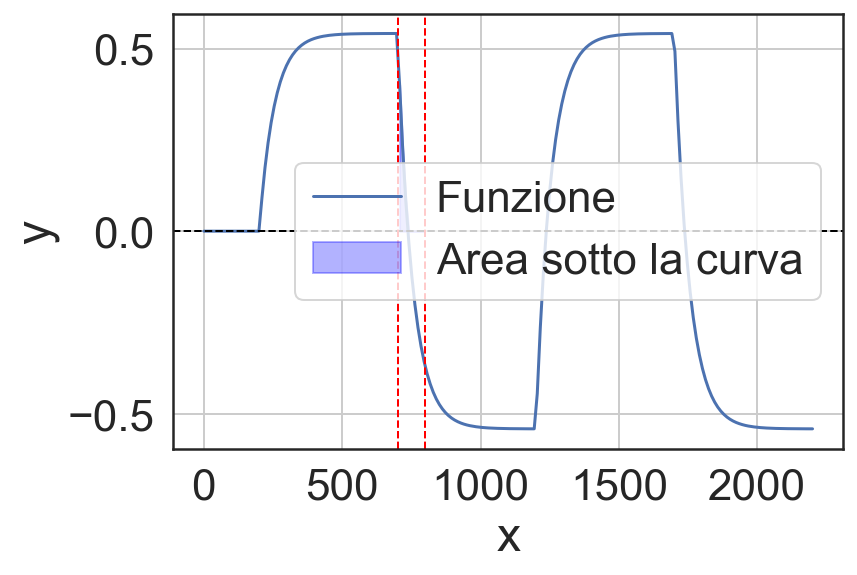

In [65]:
#single hom group simulation PLOT
%config InlineBackend.figure_format = 'retina'
# Set the seaborn style
import seaborn as sns
sns.set(font_scale=2.0)
sns.set_style("white")  # You can choose an appropriate seaborn style
# Plot the data
plt.figure(figsize=(10, 6))

value = 1
u = 0.4
z = z1
A = build_A(Na, No, alpha, beta, gamma, delta, Ao, Aa)
zs = sim_net1(z, T, Na, No, d, A, u, ue, rate, percent, value, times)
zs.y = new_zs(zs.y, Na, No)

r = performance(zs.t, zs.y[0], 700, 800, sopra_zero=True)
print(r)
r1 = performance(zs.t, zs.y[0], 700, 790, sopra_zero=True)
print(r1)
r2 = performance_old(zs.t, zs.y[0], 700, 800, sopra_zero=True)
print(r2)
r3 = performance_old(zs.t, zs.y[0], 700, 790, sopra_zero=True)
print(r3)
r4 = performance_Th(zs.t, zs.y[0], 500, 690, sopra_zero=True)
print(r4)
r5 = performance_Th(zs.t, zs.y[0], 500, 697, sopra_zero=True)
print(r5)
r6 = performance_Th(zs.t, zs.y[0], 500, 700, sopra_zero=True)
print(r6)
performance_plt(zs.t, zs.y[0], 700, 800, sopra_zero=True)
plt.show()

<Figure size 720x432 with 0 Axes>

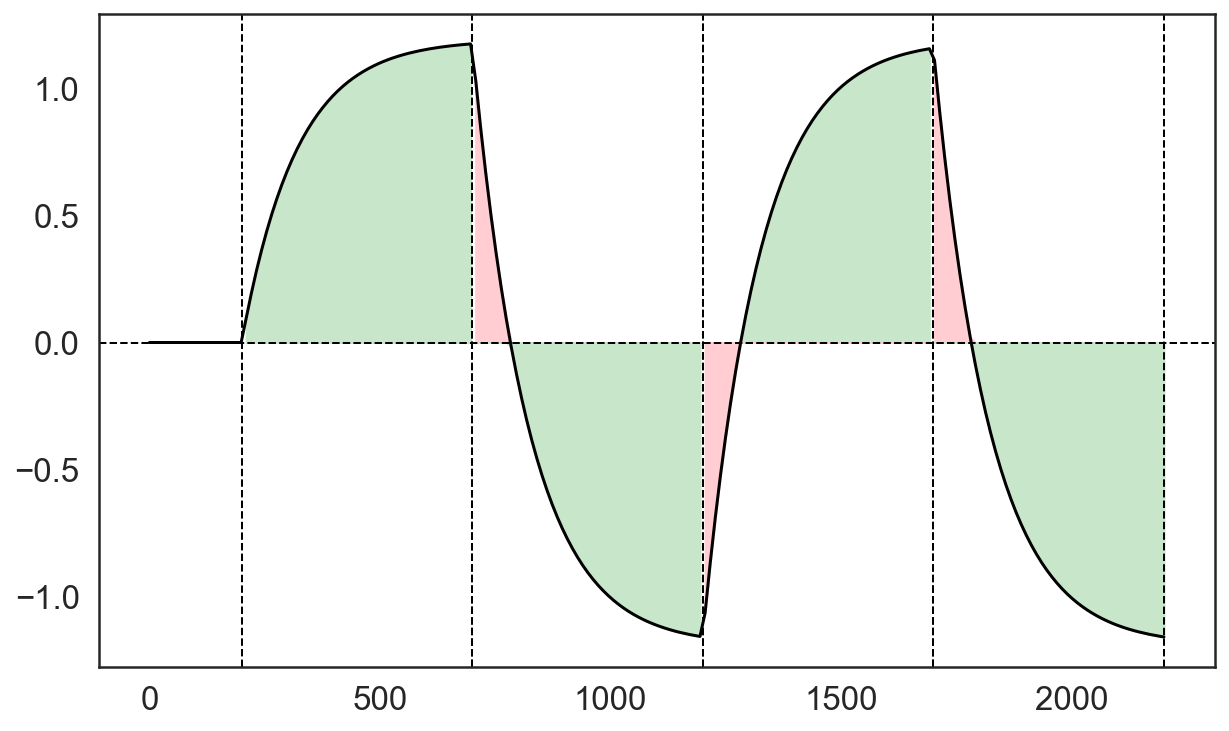

In [26]:
#single hom group simulation PLOT
%config InlineBackend.figure_format = 'retina'
# Set the seaborn style
import seaborn as sns
sns.set(font_scale=2.0)
sns.set_style("white")  # You can choose an appropriate seaborn style
# Plot the data
plt.figure(figsize=(10, 6))

value = 1
u = 3
z = z1
A = build_A(Na, No, alpha, beta, gamma, delta, Ao, Aa)
zs = sim_net1(z, T, Na, No, d, A, u, ue, rate, percent, value, times)
zs.y = new_zs(zs.y, Na, No)

performance_plt_case(zs.t, zs.y[0], 200, 700, sopra_zero=True)
#plot_agent_tot(zs.t, zs.y, Na)
#plot_agent_label(Tmin, Tmax, zs, Na, No)
plt.savefig('C:/Users/aless/OneDrive/Desktop/TESI/immagini paper cogsci/immagine1.png', dpi=400, bbox_inches='tight', pad_inches=0.5)
plt.show()

In [20]:
def performance_plt_case(x, y, x_min, x_max, sopra_zero=True):
    """
    Calcola l'area sopra o sotto la curva dati una lista di punti (x, y) nell'intervallo [x_min, x_max] utilizzando la regola di Simpson e visualizza il grafico con l'area colorata.
    
    :param x: Lista dei punti x
    :param y: Lista dei punti y (valori della funzione)
    :param x_min: Limite inferiore dell'intervallo
    :param x_max: Limite superiore dell'intervallo
    :param sopra_zero: Se True, calcola l'area sopra y=0, altrimenti calcola l'area sotto y=0.
    :return: L'area sopra o sotto la curva nell'intervallo specificato rispetto a y=0.
    """
    if len(x) != len(y):
        raise ValueError("Le liste x e y devono avere la stessa lunghezza")
        
    
    
    # Trova gli indici in cui x è all'interno dell'intervallo [x_min, x_max]
    mask = (x >= x_min) & (x <= x_max)
    x_interval = x[mask]
    y_interval = y[mask]
    
    if sopra_zero:
        y_interval = np.maximum(y_interval, 0)
    else:
        y_interval = np.minimum(y_interval, 0)
    
    area = simps(y_interval, x_interval)
    
    
    mask1 = (x >= 700) & (x <= 1200)
    x_interval1 = x[mask1]
    y_interval1 = y[mask1]

    y_interval1 = np.maximum(y_interval1, 0)
    
    area1 = simps(y_interval1, x_interval1)
    
    mask2 = (x >= 700) & (x <= 1200)
    x_interval2 = x[mask2]
    y_interval2 = y[mask2]

    y_interval2 = np.minimum(y_interval2, 0)
    
    area2 = simps(y_interval2, x_interval2)
    
    mask3 = (x >= 1200) & (x <= 1700)
    x_interval3 = x[mask3]
    y_interval3 = y[mask3]

    y_interval3 = np.maximum(y_interval3, 0)
    
    area3 = simps(y_interval3, x_interval3)
    
    mask4 = (x >= 1200) & (x <= 1700)
    x_interval4 = x[mask4]
    y_interval4 = y[mask4]

    y_interval4 = np.minimum(y_interval4, 0)
    
    area4 = simps(y_interval4, x_interval4)
    
    mask5 = (x >= 1700) & (x <= 2200)
    x_interval5 = x[mask5]
    y_interval5 = y[mask5]

    y_interval5 = np.maximum(y_interval5, 0)
    
    area5 = simps(y_interval5, x_interval5)
    
    mask6 = (x >= 1700) & (x <= 2200)
    x_interval6 = x[mask6]
    y_interval6 = y[mask6]

    y_interval6 = np.minimum(y_interval6, 0)
    
    area6 = simps(y_interval6, x_interval6)
    
    # Disegna il grafico
    sns.set(font_scale=1.5)
    sns.set_style("white")  # You can choose an appropriate seaborn style
# Plot the data
    plt.figure(figsize=(10, 6))
    #plt.figure()
    a = 1
    ca = 'black'
    good = '#C8E6C9'
    bad = '#FFCDD2'
    
    plt.plot(x, y, label='Funzione', color = 'black')
    plt.fill_between(x_interval, y_interval, alpha=a, color=good, label='Area sotto la curva')
    plt.axhline(0, color='black', linestyle='dashed', linewidth=1)
    plt.axvline(x_min, color=ca, linestyle='dashed', linewidth=1)
    plt.axvline(x_max, color=ca, linestyle='dashed', linewidth=1)
    plt.fill_between(x_interval1, y_interval1, alpha=a, color=bad, label='Area sotto la curva')
    #plt.axhline(0, color='black', linestyle='dashed', linewidth=1)
    plt.axvline(700, color=ca, linestyle='dashed', linewidth=1)
    plt.axvline(1200, color=ca, linestyle='dashed', linewidth=1)
    plt.fill_between(x_interval2, y_interval2, alpha=a, color=good, label='Area sotto la curva')
    plt.fill_between(x_interval3, y_interval3, alpha=a, color=good, label='Area sotto la curva')
    #plt.axhline(0, color='black', linestyle='dashed', linewidth=1)
    plt.axvline(1200, color=ca, linestyle='dashed', linewidth=1)
    plt.axvline(1700, color=ca, linestyle='dashed', linewidth=1)
    plt.fill_between(x_interval4, y_interval4, alpha=a, color=bad, label='Area sotto la curva')
    plt.fill_between(x_interval5, y_interval5, alpha=a, color=bad, label='Area sotto la curva')
    #plt.axhline(0, color='black', linestyle='dashed', linewidth=1)
    plt.axvline(1700, color=ca, linestyle='dashed', linewidth=1)
    plt.axvline(2200, color=ca, linestyle='dashed', linewidth=1)
    plt.fill_between(x_interval6, y_interval6, alpha=a, color=good, label='Area sotto la curva')
    
    
    #plt.ylabel('task 2 <------ a_i ------> task 1')
    #plt.xlabel('t')
    #plt.title('Performance Metric')
    #plt.legend()
    #plt.grid(True)
    #plt.show()
    
    return area

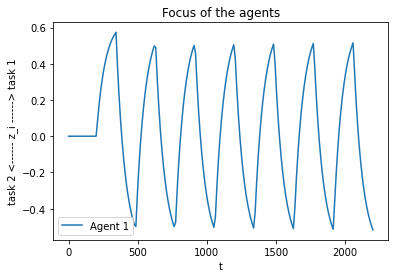

In [31]:
#single hom group simulation
u = 1.151282051282051
z = z1
A = build_A(Na, No, alpha, beta, gamma, delta, Ao, Aa)
zs = sim_net1(z, T, Na, No, d, A, u, ue, rate, percent, value, times)
zs.y = new_zs(zs.y, Na, No)

plot_agent_tot(zs.t, zs.y, Na)
#plot_agent_label(Tmin, Tmax, zs, Na, No)
plt.show()

###### come back to optimal analysis

In [33]:
u_opt

[3.8692307692307693,
 2.98974358974359,
 2.235897435897436,
 1.3564102564102565,
 0.6025641025641025,
 0.1]

In [35]:
A_value

[1551.9409328576774,
 962.8609688416093,
 707.7586674416797,
 555.0107592670468,
 455.4764931793428,
 393.1945179795785]

In [32]:
x = [0.002, 0.003, 0.004, 0.005, 0.006, 0.007]
y = [3.869231, 2.989744, 2.235897, 1.356410, 0.602564, 0.1]

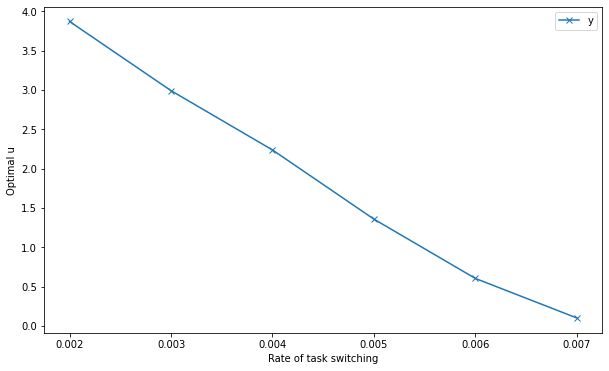

In [36]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))

plt.plot(x, y, label='y', marker='x')

plt.xlabel('Rate of task switching')
plt.ylabel('Optimal u')
plt.legend()

plt.grid(False)
plt.show()

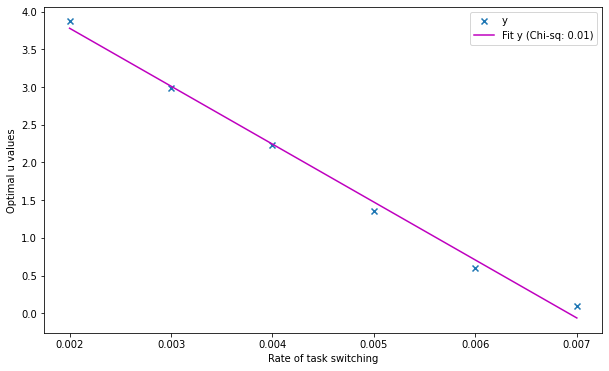

In [37]:
from scipy.optimize import curve_fit

x = np.array(x)
y = np.array(y)

# Funzione per il fitting (puoi scegliere una funzione adatta)
def func(x, a, b):
    return a * x + b
    
#def func(x, b, c):
    #return b * x + c

# Esegui il fitting per ciascun set di dati
params_1, covariance_1 = curve_fit(func, x, y)

# Calcola il chi-quadro ridotto per ciascun fit

y_fit_1 = func(x, *params_1)
chi_sq_1 = np.sum(((y - y_fit_1)**2) / (len(x) - len(params_1)))

# Creazione del grafico
plt.figure(figsize=(10, 6))

# Plotta i dati originali per ciascun set
plt.scatter(x, y, label='y', marker='x')

# Plotta i fit per ciascun set
x_fit = np.linspace(min(x), max(x), 100)
plt.plot(x_fit, func(x_fit, *params_1), 'm-', label=f'Fit y (Chi-sq: {chi_sq_1:.2f})')

# Aggiungi etichette agli assi e una legenda
plt.xlabel('Rate of task switching')
plt.ylabel('Optimal u values')
plt.legend()

# Mostra il grafico
plt.grid(False)
plt.show()

## Homogeneous Group

In [89]:
## Homogeneous Group

# case 4 agents:

Na = 4  # number of agents
No = 2  # number of tasks

#null initial conditions
z0 = np.zeros(Na*No)
#z0 = np.random.randn(Na * No) * 0.0 

z = z0
z1 = z0

# simulation run time
T = 2200

Tmin = 0
Tmax = 2200

# model parameters
d = 0.2
alpha = 0.02
beta = 0.01
gamma = 0.02
delta = 0.0
tau = 10
ue = 1

# Matrices
Ao = np.array([[1, -1], [-1, 1]])  # incongruent stimuli
Aa = np.array([[0, 1, 1, 1], [1, 0, 1, 1], [1, 1, 0, 1], [1, 1, 1, 0]])  # only positive interaction and all agents connetcted

In [90]:
us = np.linspace(0.1, 8.0, 40)
us

array([0.1       , 0.3025641 , 0.50512821, 0.70769231, 0.91025641,
       1.11282051, 1.31538462, 1.51794872, 1.72051282, 1.92307692,
       2.12564103, 2.32820513, 2.53076923, 2.73333333, 2.93589744,
       3.13846154, 3.34102564, 3.54358974, 3.74615385, 3.94871795,
       4.15128205, 4.35384615, 4.55641026, 4.75897436, 4.96153846,
       5.16410256, 5.36666667, 5.56923077, 5.77179487, 5.97435897,
       6.17692308, 6.37948718, 6.58205128, 6.78461538, 6.98717949,
       7.18974359, 7.39230769, 7.59487179, 7.7974359 , 8.        ])

In [91]:
u_opt = []
A_value = []

In [131]:
#Biases
bias_w = 0.1
value = 1
percent = 25

In [227]:
%%timeit

# n switch
T = 2200
rate = 0.007

times = find_thresh(T, rate)

3.9 µs ± 276 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [143]:
best_A = 0
best_u = 0
pe = 1.0

for u in tqdm(us):
    #print('u = ', u)
    Area = hom(u, pe, times)
    if Area > best_A:
        best_A = Area
        best_u = u
        
u_opt.append(best_u)
A_value.append(best_A)

print("Best u parameter:", best_u)
print("Best performance value:", best_A)

100%|██████████| 40/40 [00:12<00:00,  3.13it/s]

Best u parameter: 0.1
Best performance value: 393.1994557952199


In [144]:
u_opt

[6.176923076923076,
 4.758974358974359,
 3.543589743589744,
 2.1256410256410256,
 0.9102564102564102,
 0.1,
 6.176923076923076,
 4.758974358974359,
 3.543589743589744,
 2.3282051282051284,
 0.9102564102564102,
 0.1,
 6.176923076923076,
 4.758974358974359,
 3.543589743589744,
 2.1256410256410256,
 0.9102564102564102,
 0.1,
 6.176923076923076,
 4.758974358974359,
 3.543589743589744,
 2.1256410256410256,
 0.9102564102564102,
 0.1]

In [145]:
A_value

[6208.859091251688,
 3851.829600954622,
 2831.658884032054,
 2220.311554314324,
 1821.8936843772572,
 1573.1771786187103,
 4668.2623049306385,
 2890.559499328338,
 2123.798458890455,
 1664.7916984043566,
 1366.1485880775606,
 1179.9678268843875,
 3116.7521297717026,
 1928.3480909882746,
 1416.1847688783896,
 1110.0493047507798,
 911.0614906497811,
 786.779153136628,
 1558.8383289794992,
 964.2703074875608,
 708.1146788818916,
 555.1919960477612,
 455.4765906333088,
 393.1994557952199]

In [146]:
nb_sw = [4,6,8,10,12,14,4,6,8,10,12,14,4,6,8,10,12,14,4,6,8,10,12,14]
nb_biases = [4,4,4,4,4,4,3,3,3,3,3,3,2,2,2,2,2,2,1,1,1,1,1,1]

In [147]:
# Creazione del dataframe utilizzando le liste di dati
data = {'nb_biases': nb_biases,'nb_sw': nb_sw, 'optimal_u': u_opt, 'Best_performance': A_value }
df = pd.DataFrame(data)

# Salvataggio del dataframe in un file CSV
df.to_csv('./u_opt_hom_4_to_14_Hom_Group_new.csv', index=False)

In [148]:
x = [0.002, 0.003, 0.004, 0.005, 0.006, 0.007]
y_4 = [6.176923, 4.758974, 3.543590, 2.125641, 0.910256, 0.100000]
y_3 = [6.176923, 4.758974, 3.543590, 2.328205, 0.910256, 0.100000]
y_2 = [6.176923, 4.758974, 3.543590, 2.125641, 0.910256, 0.100000]
y_1 = [6.176923, 4.758974, 3.543590, 2.125641, 0.910256, 0.100000]

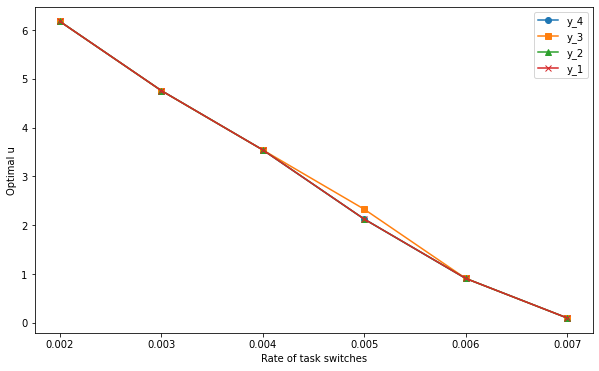

In [149]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))

plt.plot(x, y_4, label='y_4', marker='o')
plt.plot(x, y_3, label='y_3', marker='s')
plt.plot(x, y_2, label='y_2', marker='^')
plt.plot(x, y_1, label='y_1', marker='x')

plt.xlabel('Rate of task switches')
plt.ylabel('Optimal u')
plt.legend()

plt.grid(False)
plt.show()

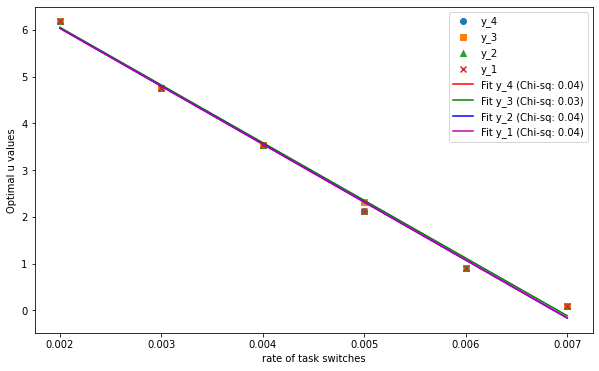

In [152]:
# Dati
x = np.array([0.002, 0.003, 0.004, 0.005, 0.006, 0.007])
y_4 = np.array([6.176923, 4.758974, 3.543590, 2.125641, 0.910256, 0.100000])
y_3 = np.array([6.176923, 4.758974, 3.543590, 2.328205, 0.910256, 0.100000])
y_2 = np.array([6.176923, 4.758974, 3.543590, 2.125641, 0.910256, 0.100000])
y_1 = np.array([6.176923, 4.758974, 3.543590, 2.125641, 0.910256, 0.100000])

# Funzione per il fitting (puoi scegliere una funzione adatta)
def func(x, a, b):
    return a * x + b
    
#def func(x, b, c):
    #return b * x + c

# Esegui il fitting per ciascun set di dati
params_4, covariance_4 = curve_fit(func, x, y_4)
params_3, covariance_3 = curve_fit(func, x, y_3)
params_2, covariance_2 = curve_fit(func, x, y_2)
params_1, covariance_1 = curve_fit(func, x, y_1)

# Calcola il chi-quadro ridotto per ciascun fit
y_fit_4 = func(x, *params_4)
chi_sq_4 = np.sum(((y_4 - y_fit_4)**2) / (len(x) - len(params_4)))

y_fit_3 = func(x, *params_3)
chi_sq_3 = np.sum(((y_3 - y_fit_3)**2) / (len(x) - len(params_3)))

y_fit_2 = func(x, *params_2)
chi_sq_2 = np.sum(((y_2 - y_fit_2)**2) / (len(x) - len(params_2)))

y_fit_1 = func(x, *params_1)
chi_sq_1 = np.sum(((y_1 - y_fit_1)**2) / (len(x) - len(params_1)))

# Creazione del grafico
plt.figure(figsize=(10, 6))

# Plotta i dati originali per ciascun set
plt.scatter(x, y_4, label='y_4', marker='o')
plt.scatter(x, y_3, label='y_3', marker='s')
plt.scatter(x, y_2, label='y_2', marker='^')
plt.scatter(x, y_1, label='y_1', marker='x')

# Plotta i fit per ciascun set
x_fit = np.linspace(min(x), max(x), 100)
plt.plot(x_fit, func(x_fit, *params_4), 'r-', label=f'Fit y_4 (Chi-sq: {chi_sq_4:.2f})')
plt.plot(x_fit, func(x_fit, *params_3), 'g-', label=f'Fit y_3 (Chi-sq: {chi_sq_3:.2f})')
plt.plot(x_fit, func(x_fit, *params_2), 'b-', label=f'Fit y_2 (Chi-sq: {chi_sq_2:.2f})')
plt.plot(x_fit, func(x_fit, *params_1), 'm-', label=f'Fit y_1 (Chi-sq: {chi_sq_1:.2f})')

# Aggiungi etichette agli assi e una legenda
plt.xlabel('rate of task switches')
plt.ylabel('Optimal u values')
plt.legend()

# Mostra il grafico
plt.grid(False)
plt.show()

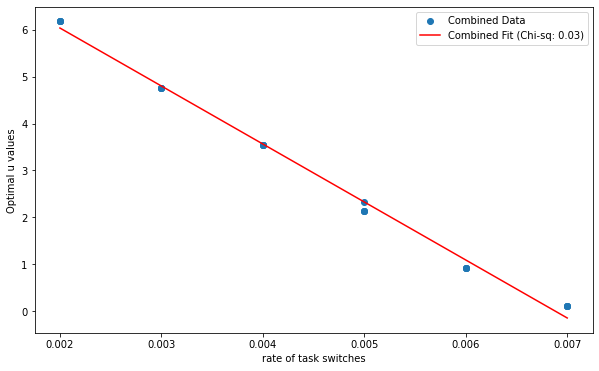

In [225]:
# Dati
x = np.array([0.002, 0.003, 0.004, 0.005, 0.006, 0.007])
y_4 = np.array([6.176923, 4.758974, 3.543590, 2.125641, 0.910256, 0.100000])
y_3 = np.array([6.176923, 4.758974, 3.543590, 2.328205, 0.910256, 0.100000])
y_2 = np.array([6.176923, 4.758974, 3.543590, 2.125641, 0.910256, 0.100000])
y_1 = np.array([6.176923, 4.758974, 3.543590, 2.125641, 0.910256, 0.100000])

# Combina tutti i dati in un unico array
x_combined = np.tile(x, 4)
y_combined = np.concatenate([y_4, y_3, y_2, y_1])

# Funzione per il fitting (puoi scegliere una funzione adatta)
def func(x, a, b):
    return a * x + b

# Esegui il fitting per tutti i dati combinati
params, covariance = curve_fit(func, x_combined, y_combined)

# Calcola il chi-quadro ridotto
y_fit = func(x_combined, *params)
chi_sq = np.sum(((y_combined - y_fit)**2) / (len(y_combined) - len(params)))

# Creazione del grafico
plt.figure(figsize=(10, 6))

# Plotta i dati originali
plt.scatter(x_combined, y_combined, label='Combined Data', marker='o')

# Plotta il fit
x_fit = np.linspace(min(x), max(x), 100)
plt.plot(x_fit, func(x_fit, *params), 'r-', label=f'Combined Fit (Chi-sq: {chi_sq:.2f})')

# Aggiungi etichette agli assi e una legenda
plt.xlabel('rate of task switches')
plt.ylabel('Optimal u values')
plt.legend()

# Mostra il grafico
plt.grid(False)
plt.show()

## Homogeneous Group but single agent performance

In [9]:
## Homogeneous Group

# case 4 agents:

Na = 4  # number of agents
No = 2  # number of tasks

#null initial conditions
z0 = np.zeros(Na*No)
#z0 = np.random.randn(Na * No) * 0.0 

z = z0
z1 = z0

# simulation run time
T = 2200

Tmin = 0
Tmax = 2200

# model parameters
d = 0.2
alpha = 0.02
beta = 0.01
gamma = 0.02
delta = 0.0
tau = 10
ue = 1

# Matrices
Ao = np.array([[1, -1], [-1, 1]])  # incongruent stimuli
Aa = np.array([[0, 1, 1, 1], [1, 0, 1, 1], [1, 1, 0, 1], [1, 1, 1, 0]])  # only positive interaction and all agents connetcted

In [10]:
us = np.linspace(0.1, 8.0, 40)
us

array([0.1       , 0.3025641 , 0.50512821, 0.70769231, 0.91025641,
       1.11282051, 1.31538462, 1.51794872, 1.72051282, 1.92307692,
       2.12564103, 2.32820513, 2.53076923, 2.73333333, 2.93589744,
       3.13846154, 3.34102564, 3.54358974, 3.74615385, 3.94871795,
       4.15128205, 4.35384615, 4.55641026, 4.75897436, 4.96153846,
       5.16410256, 5.36666667, 5.56923077, 5.77179487, 5.97435897,
       6.17692308, 6.37948718, 6.58205128, 6.78461538, 6.98717949,
       7.18974359, 7.39230769, 7.59487179, 7.7974359 , 8.        ])

In [21]:
u_opt = []
A_value = []

In [69]:
#Biases
bias_w = 0.1
value = 1
percent = 25

In [80]:
# n switch
T = 2200
rate = 0.007

times = find_thresh(T, rate)

In [81]:
best_A = 0
best_u = 0
pe = 1.0

for u in tqdm(us):
    #print('u = ', u)
    Area = hom_i(u, pe, times, 0) #the performance is evaluated on the only agent that received always the bias
    if Area > best_A:
        best_A = Area
        best_u = u
        
u_opt.append(best_u)
A_value.append(best_A)

print("Best u parameter:", best_u)
print("Best performance value:", best_A)

100%|██████████| 40/40 [00:37<00:00,  1.06it/s]

Best u parameter: 0.1
Best performance value: 393.30121956030365


In [82]:
u_opt

[6.176923076923076,
 4.758974358974359,
 3.543589743589744,
 2.1256410256410256,
 0.9102564102564102,
 0.1,
 6.176923076923076,
 4.758974358974359,
 3.543589743589744,
 2.3282051282051284,
 0.9102564102564102,
 0.1,
 6.176923076923076,
 4.961538461538462,
 3.746153846153846,
 2.3282051282051284,
 0.9102564102564102,
 0.1,
 6.176923076923076,
 5.1641025641025635,
 3.948717948717949,
 2.7333333333333334,
 1.3153846153846156,
 0.1]

In [83]:
A_value

[1552.214772812922,
 962.9574002386555,
 707.9147210080137,
 555.077888578581,
 455.4734210943143,
 393.29429465467757,
 1394.4653700911886,
 913.7104711751001,
 692.116566886301,
 551.053677684597,
 454.955628291964,
 393.35627077480547,
 1238.7538717508132,
 865.3237101891266,
 676.8549069793933,
 547.269003715009,
 454.67333639644164,
 393.4566879638701,
 1084.2927479865941,
 818.4685306698973,
 662.3307412576562,
 543.8273668113006,
 454.21905213681964,
 393.30121956030365]

Interessante notare come u cambi invece in questo caso, siccome c'è influenza del gruppo e anche performance diminuisce in base a n di agenti che ricevono bias (concorde con simulazioni grafiche).

In [84]:
nb_sw = [4,6,8,10,12,14,4,6,8,10,12,14,4,6,8,10,12,14,4,6,8,10,12,14]
nb_biases = [4,4,4,4,4,4,3,3,3,3,3,3,2,2,2,2,2,2,1,1,1,1,1,1]

In [85]:
# Creazione del dataframe utilizzando le liste di dati
data = {'nb_biases': nb_biases,'nb_sw': nb_sw, 'optimal_u': u_opt, 'Best_performance': A_value }
df = pd.DataFrame(data)

# Salvataggio del dataframe in un file CSV
df.to_csv('./u_opt_hom_4_to_14_Hom_Group_Individual.csv', index=False)

## Homogeneous Group with gamma = 0.0

##### we have to change the normalization in the function to normalize on the people the agents are really in contact with

In [155]:
## Homogeneous Group

# case 4 agents:

Na = 4  # number of agents
No = 2  # number of tasks

#null initial conditions
z0 = np.zeros(Na*No)
#z0 = np.random.randn(Na * No) * 0.0 

z = z0
z1 = z0

# simulation run time
T = 2200

Tmin = 0
Tmax = 2200

# model parameters
d = 0.2
alpha = 0.02
beta = 0.01
gamma = 0.0
delta = 0.0
tau = 10
ue = 1

# Matrices
Ao = np.array([[1, -1], [-1, 1]])  # incongruent stimuli
Aa = np.array([[0, 1, 1, 1], [1, 0, 1, 1], [1, 1, 0, 1], [1, 1, 1, 0]])  # only positive interaction and all agents connetcted

In [230]:
def zdot_net1(t, z, Na, No, d, A, u1, u2, b):
    # Return an Error if Na and No don't match the dimensions of z
    if Na * No != len(z):
        return "Na, No must match dimensions of z"

    # Define same-option and inter-option saturation functions
    def S1(z):
        return np.tanh(z)

    # assemble intra-agent matrix (1)
    z = f_64(z)
    A = f_64(A)
    
    inds = np.kron(np.ones((Na, Na)), np.eye(No)) > 0
    A_SO = np.zeros((Na * No, Na * No))
    A_SO = f_64(A_SO)
    A_SO[inds] = A[inds]
    A_SO = A_SO   
    
    # assemble same-option interactions and bias (2)
    F = (np.dot(A_SO, z))
    #F = F / Na

    F2 = np.zeros_like(F)
    F2 = f_64(F2)
    # assemble inter-option interactions about option j (3)
    for j in range(No):
        A_j = np.zeros((Na * No, Na * No))
        ind_mat = np.zeros((No, No))
        ind_mat[:, j] = np.ones(No)
        ind_mat[j, j] = 0
        ind_mat2 = np.kron(np.ones((Na, Na)), ind_mat)
        A_j[ind_mat2 > 0] = A[ind_mat2 > 0]
        F2 += np.dot(A_j, z)
    #F2 = F2 / Na

    F = F + F2
    #F = F / Na
    #F = - d * z + S1(u1 * F + b)
    F = - d * z + S1(np.multiply(u1, F) + b)
    F = F*( 1.0/tau)

    # variation of state vector z respect time
    #proj = np.eye(Na * No)
    #dz = np.dot(proj, F)
    dz = F
    #print(t, F)
    return dz

In [162]:
us = np.linspace(0.1, 5.0, 40)
us

array([0.1       , 0.22564103, 0.35128205, 0.47692308, 0.6025641 ,
       0.72820513, 0.85384615, 0.97948718, 1.10512821, 1.23076923,
       1.35641026, 1.48205128, 1.60769231, 1.73333333, 1.85897436,
       1.98461538, 2.11025641, 2.23589744, 2.36153846, 2.48717949,
       2.61282051, 2.73846154, 2.86410256, 2.98974359, 3.11538462,
       3.24102564, 3.36666667, 3.49230769, 3.61794872, 3.74358974,
       3.86923077, 3.99487179, 4.12051282, 4.24615385, 4.37179487,
       4.4974359 , 4.62307692, 4.74871795, 4.87435897, 5.        ])

In [163]:
u_opt = []
A_value = []

In [204]:
#Biases
bias_w = 0.1
value = 1
percent = 25

In [215]:
# n switch
T = 2200
rate = 0.007

times = find_thresh(T, rate)

In [216]:
best_A = 0
best_u = 0
pe = 1.0

for u in tqdm(us):
    #print('u = ', u)
    Area = hom(u, pe, times)
    if Area > best_A:
        best_A = Area
        best_u = u
        
u_opt.append(best_u)
A_value.append(best_A)

print("Best u parameter:", best_u)
print("Best performance value:", best_A)

100%|██████████| 40/40 [00:12<00:00,  3.30it/s]

Best u parameter: 0.1
Best performance value: 392.89024765594127


In [217]:
u_opt

[3.8692307692307693,
 2.98974358974359,
 2.235897435897436,
 1.3564102564102565,
 0.6025641025641025,
 0.1,
 3.8692307692307693,
 2.98974358974359,
 2.235897435897436,
 1.3564102564102565,
 0.4769230769230769,
 0.1,
 3.8692307692307693,
 2.98974358974359,
 2.235897435897436,
 1.3564102564102565,
 0.6025641025641025,
 0.1,
 3.8692307692307693,
 2.98974358974359,
 2.235897435897436,
 1.3564102564102565,
 0.4769230769230769,
 0.1]

In [218]:
A_value

[6207.177585770779,
 3851.626832338309,
 2831.625400730594,
 2220.0367854128426,
 1821.8996168235794,
 1572.7778421044648,
 4656.189156065386,
 2887.725003582504,
 2123.3300124083435,
 1665.4175792895423,
 1366.5628449467054,
 1179.3045443672163,
 3105.571396339448,
 1925.8018024186206,
 1415.4476700873183,
 1110.200858392707,
 910.7277647930717,
 786.5150731137422,
 1551.9465537886647,
 962.7954582786742,
 707.4360073750756,
 554.8737653799668,
 455.44952419850506,
 392.89024765594127]

In [219]:
nb_sw = [4,6,8,10,12,14,4,6,8,10,12,14,4,6,8,10,12,14,4,6,8,10,12,14]
nb_biases = [4,4,4,4,4,4,3,3,3,3,3,3,2,2,2,2,2,2,1,1,1,1,1,1]

In [220]:
# Creazione del dataframe utilizzando le liste di dati
data = {'nb_biases': nb_biases,'nb_sw': nb_sw, 'optimal_u': u_opt, 'Best_performance': A_value }
df = pd.DataFrame(data)

# Salvataggio del dataframe in un file CSV
df.to_csv('./u_opt_hom_4_to_14_Hom_Group_gamma_0.csv', index=False)

In [221]:
x = [0.002, 0.003, 0.004, 0.005, 0.006, 0.007]
y_4 = [3.869231, 2.989744, 2.235897, 1.356410, 0.602564, 0.100000]
y_3 = [3.869231, 2.989744, 2.235897, 1.356410, 0.476923, 0.100000]
y_2 = [3.869231, 2.989744, 2.235897, 1.356410, 0.602564, 0.100000]
y_1 = [3.869231, 2.989744, 2.235897, 1.356410, 0.476923, 0.100000]

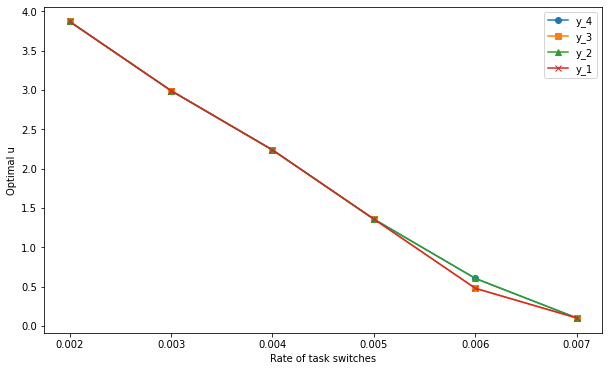

In [222]:
plt.figure(figsize=(10, 6))

plt.plot(x, y_4, label='y_4', marker='o')
plt.plot(x, y_3, label='y_3', marker='s')
plt.plot(x, y_2, label='y_2', marker='^')
plt.plot(x, y_1, label='y_1', marker='x')

plt.xlabel('Rate of task switches')
plt.ylabel('Optimal u')
plt.legend()

plt.grid(False)
plt.show()

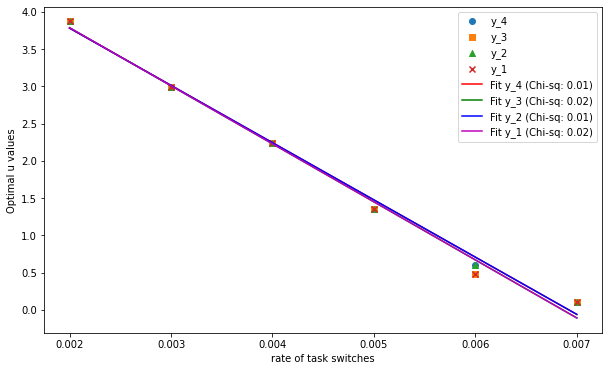

In [223]:
# Dati
x = np.array(x)
y_4 = np.array(y_4)
y_3 = np.array(y_3)
y_2 = np.array(y_2)
y_1 = np.array(y_1)

# Funzione per il fitting (puoi scegliere una funzione adatta)
def func(x, a, b):
    return a * x + b
    
#def func(x, b, c):
    #return b * x + c

# Esegui il fitting per ciascun set di dati
params_4, covariance_4 = curve_fit(func, x, y_4)
params_3, covariance_3 = curve_fit(func, x, y_3)
params_2, covariance_2 = curve_fit(func, x, y_2)
params_1, covariance_1 = curve_fit(func, x, y_1)

# Calcola il chi-quadro ridotto per ciascun fit
y_fit_4 = func(x, *params_4)
chi_sq_4 = np.sum(((y_4 - y_fit_4)**2) / (len(x) - len(params_4)))

y_fit_3 = func(x, *params_3)
chi_sq_3 = np.sum(((y_3 - y_fit_3)**2) / (len(x) - len(params_3)))

y_fit_2 = func(x, *params_2)
chi_sq_2 = np.sum(((y_2 - y_fit_2)**2) / (len(x) - len(params_2)))

y_fit_1 = func(x, *params_1)
chi_sq_1 = np.sum(((y_1 - y_fit_1)**2) / (len(x) - len(params_1)))

# Creazione del grafico
plt.figure(figsize=(10, 6))

# Plotta i dati originali per ciascun set
plt.scatter(x, y_4, label='y_4', marker='o')
plt.scatter(x, y_3, label='y_3', marker='s')
plt.scatter(x, y_2, label='y_2', marker='^')
plt.scatter(x, y_1, label='y_1', marker='x')

# Plotta i fit per ciascun set
x_fit = np.linspace(min(x), max(x), 100)
plt.plot(x_fit, func(x_fit, *params_4), 'r-', label=f'Fit y_4 (Chi-sq: {chi_sq_4:.2f})')
plt.plot(x_fit, func(x_fit, *params_3), 'g-', label=f'Fit y_3 (Chi-sq: {chi_sq_3:.2f})')
plt.plot(x_fit, func(x_fit, *params_2), 'b-', label=f'Fit y_2 (Chi-sq: {chi_sq_2:.2f})')
plt.plot(x_fit, func(x_fit, *params_1), 'm-', label=f'Fit y_1 (Chi-sq: {chi_sq_1:.2f})')

# Aggiungi etichette agli assi e una legenda
plt.xlabel('rate of task switches')
plt.ylabel('Optimal u values')
plt.legend()

# Mostra il grafico
plt.grid(False)
plt.show()

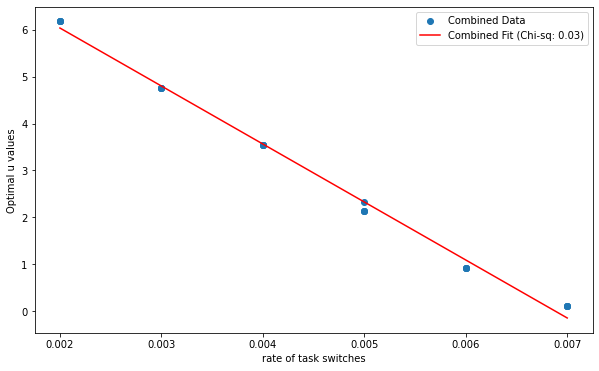

In [226]:
# Combina tutti i dati in un unico array
x_combined = np.tile(x, 4)
y_combined = np.concatenate([y_4, y_3, y_2, y_1])

# Funzione per il fitting (puoi scegliere una funzione adatta)
# Funzione per il fitting (puoi scegliere una funzione adatta)
def func(x, a, b):
    return a * x + b

# Esegui il fitting per tutti i dati combinati
params, covariance = curve_fit(func, x_combined, y_combined)

# Calcola il chi-quadro ridotto
y_fit = func(x_combined, *params)
chi_sq = np.sum(((y_combined - y_fit)**2) / (len(y_combined) - len(params)))

# Creazione del grafico
plt.figure(figsize=(10, 6))

# Plotta i dati originali
plt.scatter(x_combined, y_combined, label='Combined Data', marker='o')

# Plotta il fit
x_fit = np.linspace(min(x), max(x), 100)
plt.plot(x_fit, func(x_fit, *params), 'r-', label=f'Combined Fit (Chi-sq: {chi_sq:.2f})')

# Aggiungi etichette agli assi e una legenda
plt.xlabel('rate of task switches')
plt.ylabel('Optimal u values')
plt.legend()

# Mostra il grafico
plt.grid(False)
plt.show()

## Homogeneous Group with gamma = 0.0 but single agent performance

In [229]:
## Homogeneous Group

# case 4 agents:

Na = 4  # number of agents
No = 2  # number of tasks

#null initial conditions
z0 = np.zeros(Na*No)
#z0 = np.random.randn(Na * No) * 0.0 

z = z0
z1 = z0

# simulation run time
T = 2200

Tmin = 0
Tmax = 2200

# model parameters
d = 0.2
alpha = 0.02
beta = 0.01
gamma = 0.0
delta = 0.0
tau = 10
ue = 1

# Matrices
Ao = np.array([[1, -1], [-1, 1]])  # incongruent stimuli
Aa = np.array([[0, 1, 1, 1], [1, 0, 1, 1], [1, 1, 0, 1], [1, 1, 1, 0]])  # only positive interaction and all agents connetcted

In [232]:
us = np.linspace(0.1, 5.0, 40)
us

array([0.1       , 0.22564103, 0.35128205, 0.47692308, 0.6025641 ,
       0.72820513, 0.85384615, 0.97948718, 1.10512821, 1.23076923,
       1.35641026, 1.48205128, 1.60769231, 1.73333333, 1.85897436,
       1.98461538, 2.11025641, 2.23589744, 2.36153846, 2.48717949,
       2.61282051, 2.73846154, 2.86410256, 2.98974359, 3.11538462,
       3.24102564, 3.36666667, 3.49230769, 3.61794872, 3.74358974,
       3.86923077, 3.99487179, 4.12051282, 4.24615385, 4.37179487,
       4.4974359 , 4.62307692, 4.74871795, 4.87435897, 5.        ])

In [233]:
u_opt = []
A_value = []

In [280]:
#Biases
bias_w = 0.1
value = 1
percent = 25

In [291]:
# n switch
T = 2200
rate = 0.007

times = find_thresh(T, rate)

In [292]:
best_A = 0
best_u = 0
pe = 1.0

for u in tqdm(us):
    #print('u = ', u)
    Area = hom_i(u, pe, times, 0)
    if Area > best_A:
        best_A = Area
        best_u = u
        
u_opt.append(best_u)
A_value.append(best_A)

print("Best u parameter:", best_u)
print("Best performance value:", best_A)

100%|██████████| 40/40 [00:35<00:00,  1.12it/s]

Best u parameter: 0.1
Best performance value: 392.89024765594127


In [293]:
u_opt

[3.8692307692307693,
 2.98974358974359,
 2.235897435897436,
 1.3564102564102565,
 0.6025641025641025,
 0.1,
 3.8692307692307693,
 2.98974358974359,
 2.235897435897436,
 1.3564102564102565,
 0.4769230769230769,
 0.1,
 3.8692307692307693,
 2.98974358974359,
 2.235897435897436,
 1.3564102564102565,
 0.6025641025641025,
 0.1,
 3.8692307692307693,
 2.98974358974359,
 2.235897435897436,
 1.3564102564102565,
 0.4769230769230769,
 0.1]

In [294]:
A_value

[1551.7943964426947,
 962.9067080845773,
 707.9063501826485,
 555.0091963532107,
 455.47490420589486,
 393.1944605261162,
 1552.063052021795,
 962.5750011941681,
 707.7766708027812,
 555.1391930965141,
 455.52094831556843,
 393.1015147890721,
 1552.785698169724,
 962.9009012093103,
 707.7238350436592,
 555.1004291963535,
 455.36388239653587,
 393.2575365568711,
 1551.9465537886647,
 962.7954582786742,
 707.4360073750756,
 554.8737653799668,
 455.44952419850506,
 392.89024765594127]

osserviamo che c'è ancora una leggera variazione nei valori di performance (che in linea teorica non dovremmo trovare), ma probabilmente sempre per la precisione del solver. Tuttavia tutto comunque sembra consisente quindi vediamo se la precisione risulta abbastanza elevata per le big simulations.

In [295]:
nb_sw = [4,6,8,10,12,14,4,6,8,10,12,14,4,6,8,10,12,14,4,6,8,10,12,14]
nb_biases = [4,4,4,4,4,4,3,3,3,3,3,3,2,2,2,2,2,2,1,1,1,1,1,1]

In [296]:
# Creazione del dataframe utilizzando le liste di dati
data = {'nb_biases': nb_biases,'nb_sw': nb_sw, 'optimal_u': u_opt, 'Best_performance': A_value }
df = pd.DataFrame(data)

# Salvataggio del dataframe in un file CSV
df.to_csv('./u_opt_hom_4_to_14_Hom_Group_gamma_0_Individual.csv', index=False)

Si sono ottenuti stessi risultati con simulazione con performance di gruppo e sempre gamma = 0 e simulazione con singolo agente.

-> Ho controllato anche per i rate 0.008, 0.01, 0.012, sia per individuo che gruppo omogeneo che eterogeneo, e u ottimale continua ad essere 0.1. 

## Heterogeneous Group

Study on n = 100 simulaions of the vector_u, changing the mu of the gaussian but keeping fixed the cv = 0.5

In [8]:
# case 4 agents:

Na = 4  # number of agents
No = 2  # number of tasks

#null initial conditions
z0 = np.zeros(Na*No)
#z0 = np.random.randn(Na * No) * 0.0 

z = z0
z1 = z0

# simulation run time
T = 2200

Tmin = 0
Tmax = 2200

# model parameters
d = 0.2
alpha = 0.02
beta = 0.01
gamma = 0.02
delta = 0.0
tau = 10
ue = 1

# Matrices
Ao = np.array([[1, -1], [-1, 1]])  # incongruent stimuli
Aa = np.array([[0, 1, 1, 1], [1, 0, 1, 1], [1, 1, 0, 1], [1, 1, 1, 0]])  # only positive interaction and all agents connetcted

In [9]:
def het(mu, dev, pe, times):
    n = 100
    Areas = []

    for j in range(n):
        Ar = A1 = A11 = At = Att = Aw = Atot2 = 0
        u = u_gauss2(mu, dev, Na)
        u = np.array(u).repeat(2)
        A = build_A(Na, No, alpha, beta, gamma, delta, Ao, Aa)
        z = z1
        zs = sim_net1(z, T, Na, No, d, A, u, ue, rate, percent, value, times)
        zs.y = new_zs(zs.y, Na, No)
        
        # metric 1
        for i in range(0, Na):
            At = Att = 0
            for j in range(1, len(times)-1):
                if j % 2 != 0:
                    A1 = performance(zs.t, zs.y[i], x_min=times[j], x_max=times[j+1], sopra_zero=True)
                else:
                    A1 = abs(performance(zs.t, zs.y[i], x_min=times[j], x_max=times[j+1], sopra_zero=False))

                At += A1
            Ar += At

            for k in range(1, len(times)-1):
                if k % 2 != 0:
                    A11 = abs(performance(zs.t, zs.y[i], x_min=times[k], x_max=times[k+1], sopra_zero=False))
                else:
                    A11 = performance(zs.t, zs.y[i], x_min=times[k], x_max=times[k+1], sopra_zero=True)

                Att += A11
            Aw += Att

        Atot2 = Ar - (Aw * pe)
        Areas.append(Atot2)
        
    mean = np.mean(Areas)
    std = np.std(Areas)
    
    return mean, std

In [11]:
mus = np.linspace(0.1, 8.0, 20)
mus

array([0.1       , 0.51578947, 0.93157895, 1.34736842, 1.76315789,
       2.17894737, 2.59473684, 3.01052632, 3.42631579, 3.84210526,
       4.25789474, 4.67368421, 5.08947368, 5.50526316, 5.92105263,
       6.33684211, 6.75263158, 7.16842105, 7.58421053, 8.        ])

In [12]:
cv = 0.5

In [13]:
u_opt = []
A_value = []
dev_st = []

In [28]:
#Biases
bias_w = 0.1
value = 1
percent = 25
pe = 1.0

In [29]:
T = 2200
rates = [0.002, 0.003, 0.004 ,0.005, 0.006, 0.007]

In [30]:
def optimal_u(T, rate, mus, cv, pe):

    best_A = 0
    best_u = 0
    times = find_thresh(T, rate)

    for u in tqdm(mus):
        Area, dev = het(u, cv*u, pe, times)
        if Area > best_A:
            best_A = Area
            best_u = u
            best_dev = dev

    u_opt.append(best_u)
    A_value.append(best_A)
    dev_st.append(best_dev)

    print("Best u parameter:", best_u)
    print("Best performance value:", best_A)
    print("Best performance dev_st value:", best_dev)
    
    return u_opt, A_value, dev_st

In [31]:
for rate in tqdm(rates):
    optimal_u(T, rate, mus, cv, pe)

  0%|          | 0/20 [00:00<?, ?it/s]

Best u parameter: 5.921052631578947
Best performance value: 3055.650396683898
Best performance dev_st value: 81.22978701558134



  0%|          | 0/20 [00:00<?, ?it/s]

Best u parameter: 4.673684210526315
Best performance value: 1907.6103772963315
Best performance dev_st value: 32.92951990365785



  0%|          | 0/20 [00:00<?, ?it/s]

Best u parameter: 3.4263157894736844
Best performance value: 1410.0888240175432
Best performance dev_st value: 8.68685516201001



  0%|          | 0/20 [00:00<?, ?it/s]

Best u parameter: 2.1789473684210527
Best performance value: 1108.4621787666588
Best performance dev_st value: 2.3461650063802337



  0%|          | 0/20 [00:00<?, ?it/s]

Best u parameter: 0.9315789473684211
Best performance value: 910.7318425583824
Best performance dev_st value: 0.24461777001822937



100%|██████████| 6/6 [1:02:01<00:00, 620.24s/it]

Best u parameter: 0.1
Best performance value: 786.521149710866
Best performance dev_st value: 0.12124211741221094


In [35]:
u_opt

[6.336842105263158,
 4.673684210526315,
 3.4263157894736844,
 2.1789473684210527,
 0.9315789473684211,
 0.1,
 5.921052631578947,
 4.673684210526315,
 3.4263157894736844,
 2.1789473684210527,
 0.9315789473684211,
 0.1,
 5.921052631578947,
 4.673684210526315,
 3.4263157894736844,
 2.1789473684210527,
 0.9315789473684211,
 0.1,
 5.921052631578947,
 4.673684210526315,
 3.4263157894736844,
 2.1789473684210527,
 0.9315789473684211,
 0.1]

In [36]:
A_value

[6091.218619449946,
 3816.7116458579235,
 2819.1521200380007,
 2217.498292523382,
 1821.539762753081,
 1573.1661724056546,
 4592.223340039784,
 2861.716302977877,
 2114.568621837523,
 1663.2769756247342,
 1366.135070339389,
 1179.8263007540452,
 3055.650396683898,
 1907.6103772963315,
 1410.0888240175432,
 1108.4621787666588,
 910.7318425583824,
 786.521149710866,
 1520.1176821931,
 956.4296567374809,
 704.7515643047133,
 554.3923425151912,
 455.3197917390566,
 393.21403691851015]

In [37]:
dev_st

[79.64187600833161,
 26.181497268845355,
 8.201888032966016,
 2.5925512144501344,
 0.3398365108856957,
 0.1593367476766876,
 64.89653039378197,
 26.921674527173003,
 9.61451205826364,
 2.1928332291172663,
 0.30077465510448653,
 0.13150938669124024,
 81.22978701558134,
 32.92951990365785,
 8.68685516201001,
 2.3461650063802337,
 0.24461777001822937,
 0.12124211741221094,
 69.75774146144505,
 17.96690118648715,
 6.853851706261412,
 1.6746742206869285,
 0.20542454802346446,
 0.09376750700517736]

In [38]:
nb_sw = [4,6,8,10,12,14,4,6,8,10,12,14,4,6,8,10,12,14,4,6,8,10,12,14]
nb_biases = [4,4,4,4,4,4,3,3,3,3,3,3,2,2,2,2,2,2,1,1,1,1,1,1]

In [39]:
# Creazione del dataframe utilizzando le liste di dati
data = {'nb_biases': nb_biases,'nb_sw': nb_sw, 'optimal_u': u_opt, 'Best_performance': A_value, 'Dev_st_best_performance': dev_st}
df = pd.DataFrame(data)

# Salvataggio del dataframe in un file CSV
df.to_csv('./u_opt_hom_4_to_14_Het_Group_gamma_cv_0.5.csv', index=False)

##### plot made with the right range of u

In [10]:
x = [0.002, 0.003, 0.004, 0.005, 0.006, 0.007]
y_4 = [6.176923, 4.758974, 3.341025, 2.125641, 0.910256, 0.100000]
y_3 = [5.974358, 4.758974, 3.543589, 2.125641, 0.910256, 0.100000]
y_2 = [5.974358, 4.758974, 3.341025, 2.125641, 0.910256, 0.100000]
y_1 = [5.974358, 4.556410, 3.341025, 2.125641, 0.910256, 0.100000]

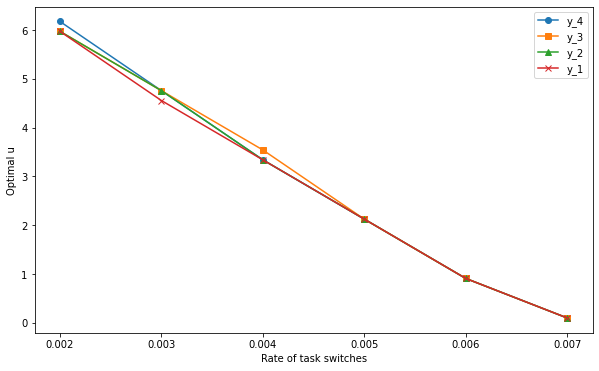

In [10]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))

plt.plot(x, y_4, label='y_4', marker='o')
plt.plot(x, y_3, label='y_3', marker='s')
plt.plot(x, y_2, label='y_2', marker='^')
plt.plot(x, y_1, label='y_1', marker='x')

plt.xlabel('Rate of task switches')
plt.ylabel('Optimal u')
plt.legend()

plt.grid(False)
plt.show()

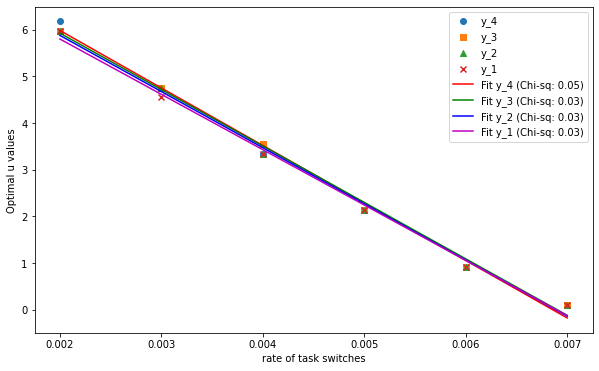

In [11]:
# Dati
x = np.array([0.002, 0.003, 0.004, 0.005, 0.006, 0.007])
y_4 = np.array([6.176923, 4.758974, 3.341025, 2.125641, 0.910256, 0.100000])
y_3 = np.array([5.974358, 4.758974, 3.543589, 2.125641, 0.910256, 0.100000])
y_2 = np.array([5.974358, 4.758974, 3.341025, 2.125641, 0.910256, 0.100000])
y_1 = np.array([5.974358, 4.556410, 3.341025, 2.125641, 0.910256, 0.100000])

# Funzione per il fitting (puoi scegliere una funzione adatta)
def func(x, a, b):
    return a * x + b
    
#def func(x, b, c):
    #return b * x + c

# Esegui il fitting per ciascun set di dati
params_4, covariance_4 = curve_fit(func, x, y_4)
params_3, covariance_3 = curve_fit(func, x, y_3)
params_2, covariance_2 = curve_fit(func, x, y_2)
params_1, covariance_1 = curve_fit(func, x, y_1)

# Calcola il chi-quadro ridotto per ciascun fit
y_fit_4 = func(x, *params_4)
chi_sq_4 = np.sum(((y_4 - y_fit_4)**2) / (len(x) - len(params_4)))

y_fit_3 = func(x, *params_3)
chi_sq_3 = np.sum(((y_3 - y_fit_3)**2) / (len(x) - len(params_3)))

y_fit_2 = func(x, *params_2)
chi_sq_2 = np.sum(((y_2 - y_fit_2)**2) / (len(x) - len(params_2)))

y_fit_1 = func(x, *params_1)
chi_sq_1 = np.sum(((y_1 - y_fit_1)**2) / (len(x) - len(params_1)))

# Creazione del grafico
plt.figure(figsize=(10, 6))

# Plotta i dati originali per ciascun set
plt.scatter(x, y_4, label='y_4', marker='o')
plt.scatter(x, y_3, label='y_3', marker='s')
plt.scatter(x, y_2, label='y_2', marker='^')
plt.scatter(x, y_1, label='y_1', marker='x')

# Plotta i fit per ciascun set
x_fit = np.linspace(min(x), max(x), 100)
plt.plot(x_fit, func(x_fit, *params_4), 'r-', label=f'Fit y_4 (Chi-sq: {chi_sq_4:.2f})')
plt.plot(x_fit, func(x_fit, *params_3), 'g-', label=f'Fit y_3 (Chi-sq: {chi_sq_3:.2f})')
plt.plot(x_fit, func(x_fit, *params_2), 'b-', label=f'Fit y_2 (Chi-sq: {chi_sq_2:.2f})')
plt.plot(x_fit, func(x_fit, *params_1), 'm-', label=f'Fit y_1 (Chi-sq: {chi_sq_1:.2f})')

# Aggiungi etichette agli assi e una legenda
plt.xlabel('rate of task switches')
plt.ylabel('Optimal u values')
plt.legend()

# Mostra il grafico
plt.grid(False)
plt.show()

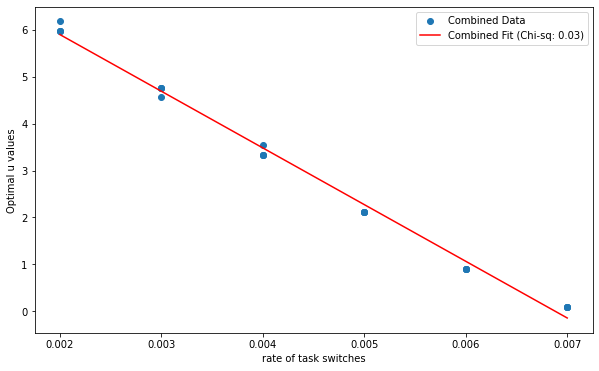

In [12]:
# Dati
x = np.array([0.002, 0.003, 0.004, 0.005, 0.006, 0.007])
y_4 = np.array([6.176923, 4.758974, 3.341025, 2.125641, 0.910256, 0.100000])
y_3 = np.array([5.974358, 4.758974, 3.543589, 2.125641, 0.910256, 0.100000])
y_2 = np.array([5.974358, 4.758974, 3.341025, 2.125641, 0.910256, 0.100000])
y_1 = np.array([5.974358, 4.556410, 3.341025, 2.125641, 0.910256, 0.100000])

# Combina tutti i dati in un unico array
x_combined = np.tile(x, 4)
y_combined = np.concatenate([y_4, y_3, y_2, y_1])

# Funzione per il fitting (puoi scegliere una funzione adatta)
def func(x, a, b):
    return a * x + b

# Esegui il fitting per tutti i dati combinati
params, covariance = curve_fit(func, x_combined, y_combined)

# Calcola il chi-quadro ridotto
y_fit = func(x_combined, *params)
chi_sq = np.sum(((y_combined - y_fit)**2) / (len(y_combined) - len(params)))

# Creazione del grafico
plt.figure(figsize=(10, 6))

# Plotta i dati originali
plt.scatter(x_combined, y_combined, label='Combined Data', marker='o')

# Plotta il fit
x_fit = np.linspace(min(x), max(x), 100)
plt.plot(x_fit, func(x_fit, *params), 'r-', label=f'Combined Fit (Chi-sq: {chi_sq:.2f})')

# Aggiungi etichette agli assi e una legenda
plt.xlabel('rate of task switches')
plt.ylabel('Optimal u values')
plt.legend()

# Mostra il grafico
plt.grid(False)
plt.show()

### Better Plots

In [11]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import solve_ivp
import networkx as nx
import seaborn as sns  # Import seaborn
import matplotlib.cm as cm
from itertools import product
from matplotlib.lines import Line2D
import random
import scipy.stats as stats
from tqdm import tqdm
from IPython.display import Video
from matplotlib.colors import ListedColormap
import colorsys
import matplotlib
import matplotlib.colors
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt

import seaborn as sns
sns.set(style='whitegrid')  # Use an appropriate seaborn style
#plt.style.use('seaborn')
%config InlineBackend.figure_format = 'retina'

sns.set(style='whitegrid') 

def set_size(w,h):
    """Set matplot figure size"""
    plt.rcParams["figure.figsize"] = [w,h]

def get_alpha_cmap(cmap):
    if isinstance(cmap, str):
        cmap = plt.get_cmap(cmap)
    else:
        c = np.array((cmap[0]/255.0, cmap[1]/255.0, cmap[2]/255.0))

        cmax = colorsys.rgb_to_hls(*c)
        cmax = np.array(cmax)
        cmax[-1] = 1.0

        cmax = np.clip(np.array(colorsys.hls_to_rgb(*cmax)), 0, 1)
        #cmax = np.clip(c * 1.2, 0, 1)
        cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", [c,cmax])

    alpha_cmap = cmap(np.arange(256))
    alpha_cmap[:,-1] = np.linspace(0, 1.0, 256)
    alpha_cmap = ListedColormap(alpha_cmap)

    return alpha_cmap

slack_blue  = get_alpha_cmap((54, 197, 240))
slack_green = get_alpha_cmap((46, 182, 125) )
slack_red   = get_alpha_cmap((210, 40, 95))
slack_yellow = get_alpha_cmap((236, 178, 46))
slack_violet = get_alpha_cmap((84, 25, 85))

google_blue = get_alpha_cmap((66, 133, 244))
google_red = get_alpha_cmap((219, 68, 55))
google_yellow= get_alpha_cmap((244, 180, 0))
google_green = get_alpha_cmap((15, 157, 88))

deep_purple = get_alpha_cmap((103, 58, 183))
pink = get_alpha_cmap((236, 64, 122))
anthracite = get_alpha_cmap((42, 72, 88))

#cmaps = [google_blue, slack_green, google_red, slack_yellow, slack_violet, deep_purple, pink, anthracite]
cmaps = [anthracite, slack_violet, google_green, slack_blue]
colors = ['#0C5DA5', '#00B945', '#FF9500', '#FF2C00', '#845B97', '#474747', '#9e9e9e']

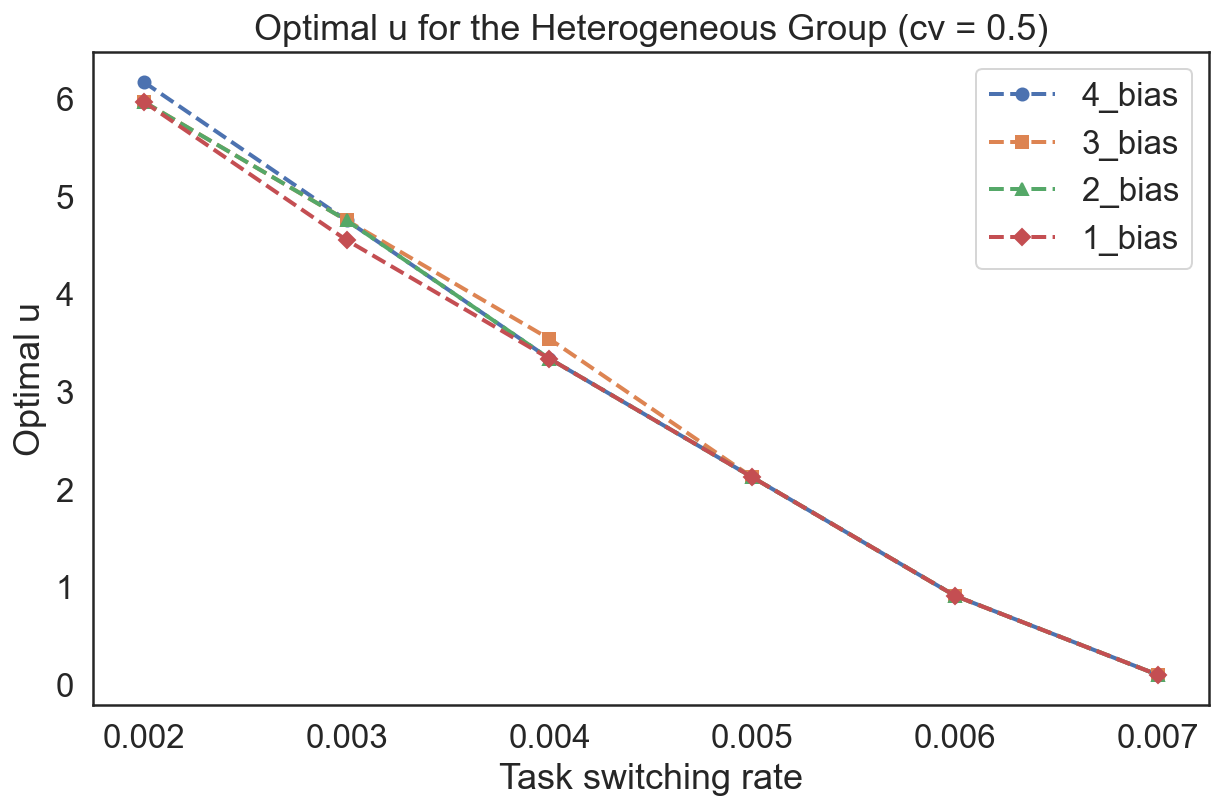

In [14]:
import seaborn as sns

# Define the new data
x = np.array([0.002, 0.003, 0.004, 0.005, 0.006, 0.007])
y_4 = np.array([6.176923, 4.758974, 3.341025, 2.125641, 0.910256, 0.100000])
y_3 = np.array([5.974358, 4.758974, 3.543589, 2.125641, 0.910256, 0.100000])
y_2 = np.array([5.974358, 4.758974, 3.341025, 2.125641, 0.910256, 0.100000])
y_1 = np.array([5.974358, 4.556410, 3.341025, 2.125641, 0.910256, 0.100000])

# Set the seaborn style
sns.set(font_scale=1.5)
sns.set_style("white")  # You can choose an appropriate seaborn style

# Plot the data
plt.figure(figsize=(10, 6))

# Plot for y_4
plt.plot(x, y_4, linewidth=2.0, linestyle="--", marker='o', label='4_bias')

# Plot for y_3
plt.plot(x, y_3, linewidth=2.0, linestyle="--", marker='s', label='3_bias')

# Plot for y_2
plt.plot(x, y_2, linewidth=2.0, linestyle="--", marker='^', label='2_bias')

# Plot for y_1
plt.plot(x, y_1, linewidth=2.0, linestyle="--", marker='D', label='1_bias')

plt.xlabel('Task switching rate')
plt.ylabel('Optimal u')
plt.xticks(x, x)

plt.legend()
plt.title('Optimal u for the Heterogeneous Group (cv = 0.5)')
plt.show()

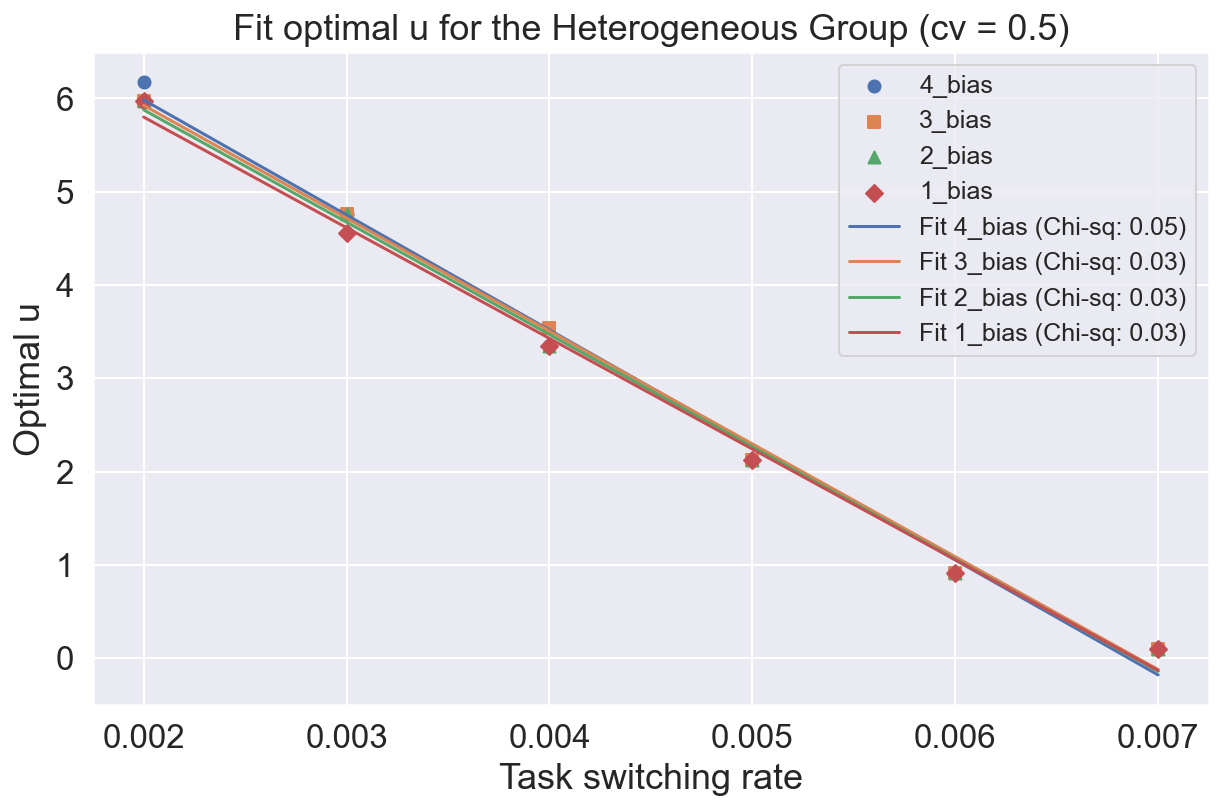

In [15]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Dati
x = np.array([0.002, 0.003, 0.004, 0.005, 0.006, 0.007])
y_4 = np.array([6.176923, 4.758974, 3.341025, 2.125641, 0.910256, 0.100000])
y_3 = np.array([5.974358, 4.758974, 3.543589, 2.125641, 0.910256, 0.100000])
y_2 = np.array([5.974358, 4.758974, 3.341025, 2.125641, 0.910256, 0.100000])
y_1 = np.array([5.974358, 4.556410, 3.341025, 2.125641, 0.910256, 0.100000])

sns.set(font_scale=1.5)
sns.set_style("darkgrid")  # You can choose an appropriate seaborn style

# Funzione per il fitting (funzione quadratica)
def func(x, a, b):
    return a * x + b

# Esegui il fitting per ciascun set di dati
params_4, covariance_4 = curve_fit(func, x, y_4)
params_3, covariance_3 = curve_fit(func, x, y_3)
params_2, covariance_2 = curve_fit(func, x, y_2)
params_1, covariance_1 = curve_fit(func, x, y_1)

# Calcola il chi-quadro ridotto per ciascun fit
y_fit_4 = func(x, *params_4)
chi_sq_4 = np.sum(((y_4 - y_fit_4)**2) / (len(x) - len(params_4)))

y_fit_3 = func(x, *params_3)
chi_sq_3 = np.sum(((y_3 - y_fit_3)**2) / (len(x) - len(params_3)))

y_fit_2 = func(x, *params_2)
chi_sq_2 = np.sum(((y_2 - y_fit_2)**2) / (len(x) - len(params_2)))

y_fit_1 = func(x, *params_1)
chi_sq_1 = np.sum(((y_1 - y_fit_1)**2) / (len(x) - len(params_1)))

# Creazione del grafico
plt.figure(figsize=(10, 6))

# Plotta i dati originali per ciascun set
plt.scatter(x, y_4, label='4_bias', marker='o')
plt.scatter(x, y_3, label='3_bias', marker='s')
plt.scatter(x, y_2, label='2_bias', marker='^')
plt.scatter(x, y_1, label='1_bias', marker='D')

# Plotta i fit per ciascun set
x_fit = np.linspace(min(x), max(x), 100)
plt.plot(x_fit, func(x_fit, *params_4), label=f'Fit 4_bias (Chi-sq: {chi_sq_4:.2f})')
plt.plot(x_fit, func(x_fit, *params_3), label=f'Fit 3_bias (Chi-sq: {chi_sq_3:.2f})')
plt.plot(x_fit, func(x_fit, *params_2), label=f'Fit 2_bias (Chi-sq: {chi_sq_2:.2f})')
plt.plot(x_fit, func(x_fit, *params_1), label=f'Fit 1_bias (Chi-sq: {chi_sq_1:.2f})')

# Aggiungi etichette agli assi e una legenda
plt.xlabel('Task switching rate')
plt.ylabel('Optimal u')
plt.legend(fontsize='x-small')

# Mostra il grafico
plt.title('Fit optimal u for the Heterogeneous Group (cv = 0.5)')
plt.grid(True)
plt.show()


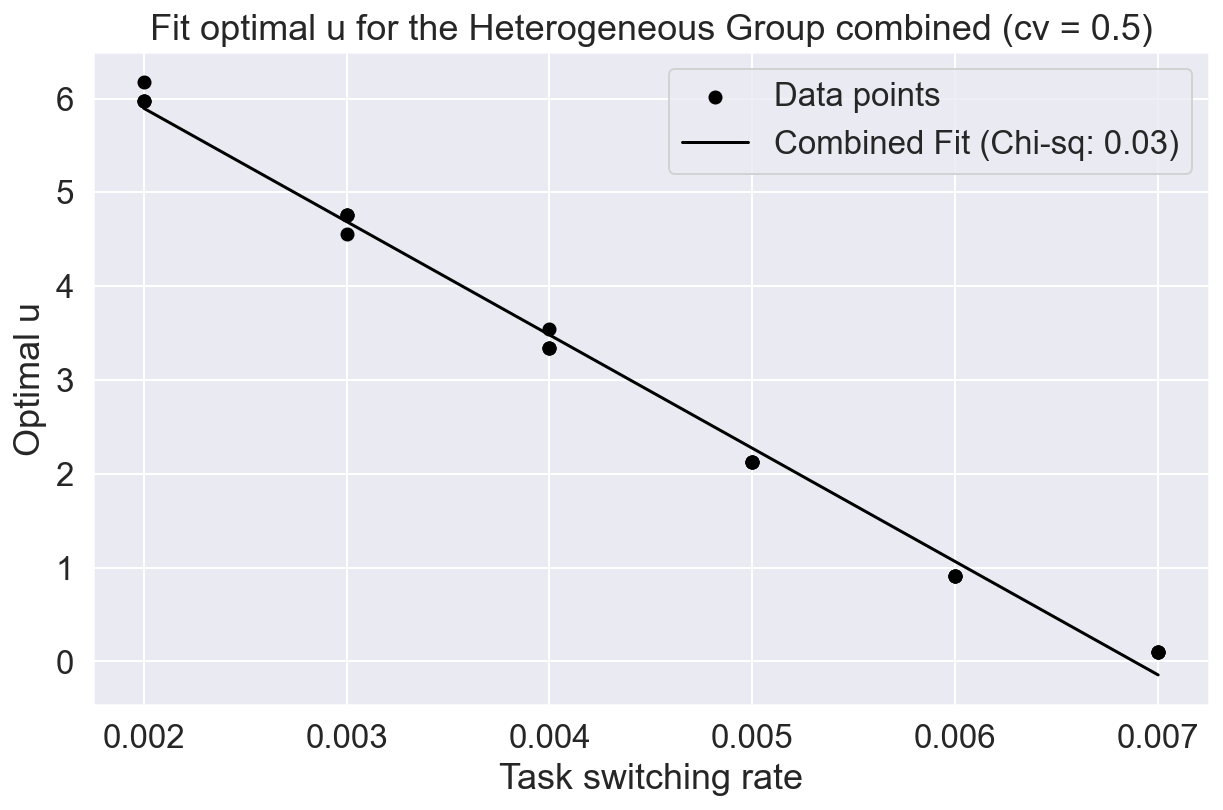

In [16]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Dati
x = np.array([0.002, 0.003, 0.004, 0.005, 0.006, 0.007])
y_4 = np.array([6.176923, 4.758974, 3.341025, 2.125641, 0.910256, 0.100000])
y_3 = np.array([5.974358, 4.758974, 3.543589, 2.125641, 0.910256, 0.100000])
y_2 = np.array([5.974358, 4.758974, 3.341025, 2.125641, 0.910256, 0.100000])
y_1 = np.array([5.974358, 4.556410, 3.341025, 2.125641, 0.910256, 0.100000])

# Combina tutti i dati in un unico array
x_combined = np.tile(x, 4)
y_combined = np.concatenate([y_4, y_3, y_2, y_1])

# Funzione per il fitting (lineare)
def func(x, a, b):
    return a * x + b

# Esegui il fitting per tutti i dati combinati
params, covariance = curve_fit(func, x_combined, y_combined)

# Calcola il chi-quadro ridotto
y_fit = func(x_combined, *params)
chi_sq = np.sum(((y_combined - y_fit)**2) / (len(y_combined) - len(params)))

# Creazione del grafico
plt.figure(figsize=(10, 6))

# Plotta i dati originali
plt.scatter(x_combined, y_combined, color = 'black', label='Data points', marker='o')

# Plotta il fit
x_fit = np.linspace(min(x), max(x), 100)
plt.plot(x_fit, func(x_fit, *params), color = 'black', label=f'Combined Fit (Chi-sq: {chi_sq:.2f})')

# Aggiungi etichette agli assi e una legenda
plt.xlabel('Task switching rate')
plt.ylabel('Optimal u')
plt.legend()

# Applica lo stile del plot precedente
#plt.style.use('seaborn')
# Set the seaborn style
sns.set(font_scale=1.5)
sns.set_style("darkgrid")  # You can choose an appropriate seaborn style


# Mostra il grafico
plt.title('Fit optimal u for the Heterogeneous Group combined (cv = 0.5)')
plt.grid(True)
plt.show()

### Plot individual, hom group, het group combined

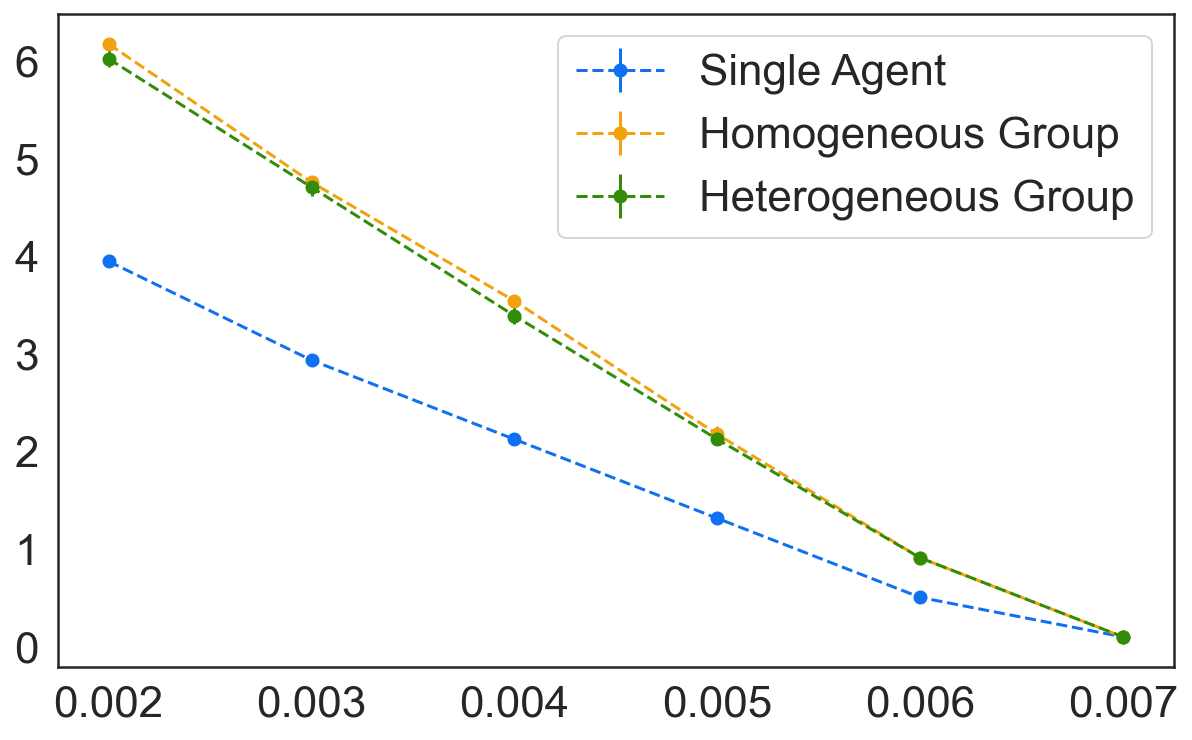

In [20]:
# Set the seaborn style
sns.set(font_scale=2.0)
sns.set_style("white")  # You can choose an appropriate seaborn style
# Plot the data
plt.figure(figsize=(10, 6))

# Set 1
x_set1 = np.array([0.002, 0.003, 0.004, 0.005, 0.006, 0.007])
y_set1 = np.array([3.948717, 2.935897, 2.125641, 1.315384, 0.505128, 0.1])

# Set 2
x_set2 = np.array([0.002, 0.003, 0.004, 0.005, 0.006, 0.007])
y_4_set2 = np.array([6.176923, 4.758974, 3.543590, 2.125641, 0.910256, 0.100000])
y_3_set2 = np.array([6.176923, 4.758974, 3.543590, 2.328205, 0.910256, 0.100000])
y_2_set2 = np.array([6.176923, 4.758974, 3.543590, 2.125641, 0.910256, 0.100000])
y_1_set2 = np.array([6.176923, 4.758974, 3.543590, 2.125641, 0.910256, 0.100000])

# Set 3
x_set3 = np.array([0.002, 0.003, 0.004, 0.005, 0.006, 0.007])
y_4_set3 = np.array([6.176923, 4.758974, 3.341025, 2.125641, 0.910256, 0.100000])
y_3_set3 = np.array([5.974358, 4.758974, 3.543589, 2.125641, 0.910256, 0.100000])
y_2_set3 = np.array([5.974358, 4.758974, 3.341025, 2.125641, 0.910256, 0.100000])
y_1_set3 = np.array([5.974358, 4.556410, 3.341025, 2.125641, 0.910256, 0.100000])

# Calcola la media degli elementi nei 4 vettori y per ogni set
y_new_set1 = np.mean([y_set1], axis=0)
y_new_set2 = np.mean([y_4_set2, y_3_set2, y_2_set2, y_1_set2], axis=0)
y_new_set3 = np.mean([y_4_set3, y_3_set3, y_2_set3, y_1_set3], axis=0)

# Calcola la deviazione standard per ogni set
std_set1 = 0.0
std_set2 = np.std([y_4_set2, y_3_set2, y_2_set2, y_1_set2], axis=0)
std_set3 = np.std([y_4_set3, y_3_set3, y_2_set3, y_1_set3], axis=0)

# Plotting
plt.errorbar(x_set1, y_new_set1, yerr=std_set1, label='Single Agent',  linestyle="--", marker='o', color = '#0F71F2')
plt.errorbar(x_set2, y_new_set2, yerr=std_set2, label='Homogeneous Group',  linestyle="--",  marker='o', color = '#F2A20C')
plt.errorbar(x_set3, y_new_set3, yerr=std_set3, label='Heterogeneous Group',  linestyle="--", marker='o', color = '#318C07')

#plt.xlabel('Task switching rate')
#plt.ylabel('Optimal u values')
plt.legend()
#plt.title('Optimal u')
plt.gcf().patch.set_facecolor('white')
plt.savefig('C:/Users/aless/OneDrive/Desktop/TESI/immagini paper cogsci/immagine.png', dpi=400, bbox_inches='tight', pad_inches=0.5)
plt.show()


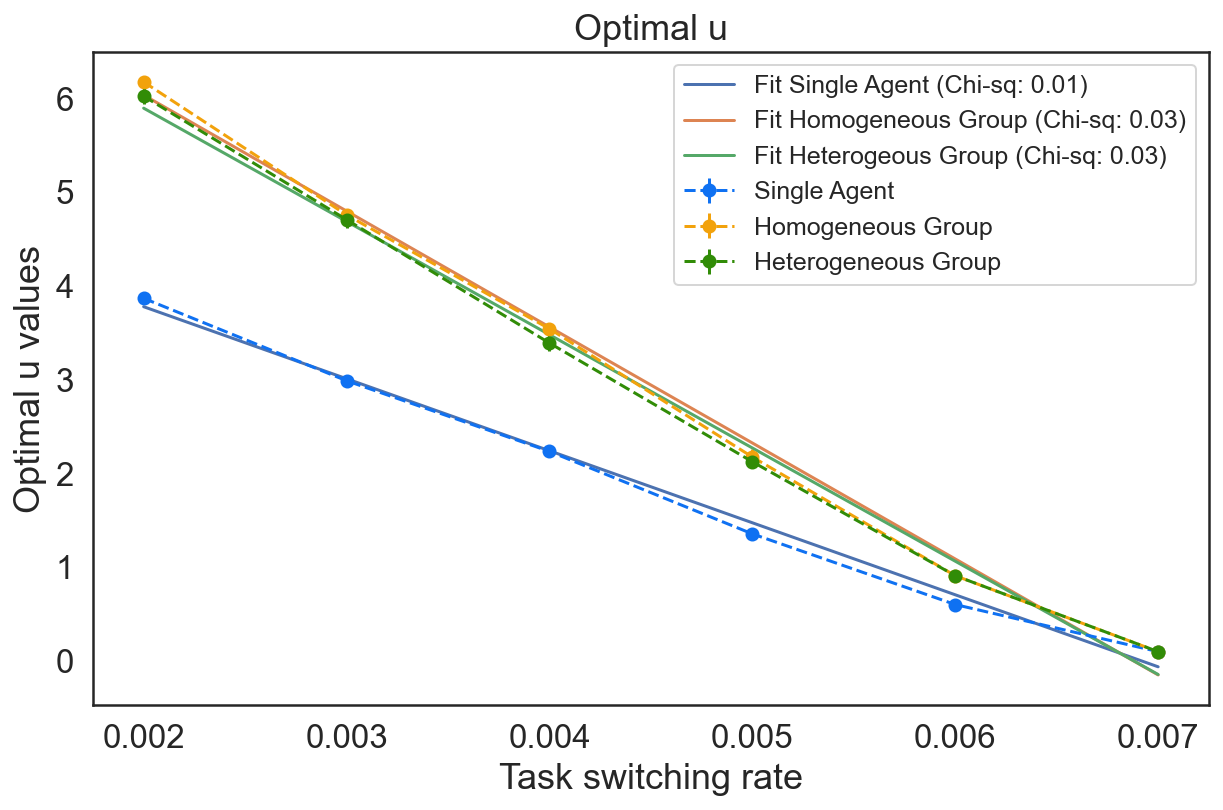

In [12]:
# Set the seaborn style
sns.set(font_scale=1.5)
sns.set_style("white")  # You can choose an appropriate seaborn style
# Plot the data
plt.figure(figsize=(10, 6))

# Set 1
x_set1 = np.array([0.002, 0.003, 0.004, 0.005, 0.006, 0.007])
y_set1 = np.array([3.869231, 2.989744, 2.235897, 1.356410, 0.602564, 0.1])

# Set 2
x_set2 = np.array([0.002, 0.003, 0.004, 0.005, 0.006, 0.007])
y_4_set2 = np.array([6.176923, 4.758974, 3.543590, 2.125641, 0.910256, 0.100000])
y_3_set2 = np.array([6.176923, 4.758974, 3.543590, 2.328205, 0.910256, 0.100000])
y_2_set2 = np.array([6.176923, 4.758974, 3.543590, 2.125641, 0.910256, 0.100000])
y_1_set2 = np.array([6.176923, 4.758974, 3.543590, 2.125641, 0.910256, 0.100000])

# Set 3
x_set3 = np.array([0.002, 0.003, 0.004, 0.005, 0.006, 0.007])
y_4_set3 = np.array([6.176923, 4.758974, 3.341025, 2.125641, 0.910256, 0.100000])
y_3_set3 = np.array([5.974358, 4.758974, 3.543589, 2.125641, 0.910256, 0.100000])
y_2_set3 = np.array([5.974358, 4.758974, 3.341025, 2.125641, 0.910256, 0.100000])
y_1_set3 = np.array([5.974358, 4.556410, 3.341025, 2.125641, 0.910256, 0.100000])

# Calcola la media degli elementi nei 4 vettori y per ogni set
y_new_set1 = np.mean([y_set1], axis=0)
y_new_set2 = np.mean([y_4_set2, y_3_set2, y_2_set2, y_1_set2], axis=0)
y_new_set3 = np.mean([y_4_set3, y_3_set3, y_2_set3, y_1_set3], axis=0)

# Calcola la deviazione standard per ogni set
std_set1 = 0.0
std_set2 = np.std([y_4_set2, y_3_set2, y_2_set2, y_1_set2], axis=0)
std_set3 = np.std([y_4_set3, y_3_set3, y_2_set3, y_1_set3], axis=0)

# Plotting
plt.errorbar(x_set1, y_new_set1, yerr=std_set1, label='Single Agent',  linestyle="--", marker='o', color = '#0F71F2')
plt.errorbar(x_set2, y_new_set2, yerr=std_set2, label='Homogeneous Group',  linestyle="--",  marker='o', color = '#F2A20C')
plt.errorbar(x_set3, y_new_set3, yerr=std_set3, label='Heterogeneous Group',  linestyle="--", marker='o', color = '#318C07')

# Funzione per il fitting (funzione quadratica)
def func(x, a, b):
    return a * x + b

# Esegui il fitting per ciascun set di dati
params_1, covariance_1 = curve_fit(func, x_set1, y_new_set1)
params_2, covariance_2 = curve_fit(func, x_set2, y_new_set2)
params_3, covariance_3 = curve_fit(func, x_set3, y_new_set3)

# Calcola il chi-quadro ridotto per ciascun fit

y_fit_1 = func(x_set1, *params_1)
chi_sq_1 = np.sum(((y_new_set1 - y_fit_1)**2) / (len(x_set1) - len(params_1)))

y_fit_2 = func(x_set2, *params_2)
chi_sq_2 = np.sum(((y_new_set2 - y_fit_2)**2) / (len(x_set2) - len(params_2)))

y_fit_3 = func(x_set3, *params_3)
chi_sq_3 = np.sum(((y_new_set3 - y_fit_3)**2) / (len(x_set3) - len(params_3)))


# Creazione del grafico
#plt.figure(figsize=(10, 6))

# Plotta i dati originali per ciascun set
#plt.scatter(x, y_3, label='3_bias', marker='s')
#plt.scatter(x, y_2, label='2_bias', marker='^')
#plt.scatter(x, y_1, label='1_bias', marker='D')

# Plotta i fit per ciascun set
x_fit1 = np.linspace(min(x_set1), max(x_set1), 100)
x_fit2 = np.linspace(min(x_set2), max(x_set2), 100)
x_fit3 = np.linspace(min(x_set3), max(x_set3), 100)
plt.plot(x_fit1, func(x_fit1, *params_1), label=f'Fit Single Agent (Chi-sq: {chi_sq_1:.2f})')
plt.plot(x_fit2, func(x_fit2, *params_2), label=f'Fit Homogeneous Group (Chi-sq: {chi_sq_2:.2f})')
plt.plot(x_fit3, func(x_fit3, *params_3), label=f'Fit Heterogeous Group (Chi-sq: {chi_sq_3:.2f})')

# Aggiungi etichette agli assi e una legenda
#plt.xlabel('Task switching rate')
#plt.ylabel('Optimal u')


plt.xlabel('Task switching rate')
plt.ylabel('Optimal u values')
plt.legend(fontsize='x-small')
plt.title('Optimal u')
plt.gcf().patch.set_facecolor('white')
plt.savefig('C:/Users/aless/OneDrive/Desktop/TESI/immagini paper cogsci/immagine.png', dpi=300, bbox_inches='tight', pad_inches=0.5)
plt.show()

# Mostra il grafico
#plt.title('Fit optimal u for the Heterogeneous Group (cv = 0.5)')
#plt.grid(True)
#plt.show()


In [13]:
#number of degree of freedom in the test
(len(x_set3) - len(params_3))

4

## fixed u, change cv

Study on n= 100 simulaions of the vector_u, changing the cv of the gaussian but keeping fixed the u_fixed = 4.0

In [92]:
# case 4 agents:

Na = 4  # number of agents
No = 2  # number of tasks

#null initial conditions
z0 = np.zeros(Na*No)
#z0 = np.random.randn(Na * No) * 0.0 

z = z0
z1 = z0

# simulation run time
T = 2200

Tmin = 0
Tmax = 2200

# model parameters
d = 0.2
alpha = 0.02
beta = 0.01
gamma = 0.02
delta = 0.0
tau = 10
ue = 1

# Matrices
Ao = np.array([[1, -1], [-1, 1]])  # incongruent stimuli
Aa = np.array([[0, 1, 1, 1], [1, 0, 1, 1], [1, 1, 0, 1], [1, 1, 1, 0]])  # only positive interaction and all agents connetcted

In [93]:
cvs = np.linspace(0.0, 1.0, 6)
cvs

array([0. , 0.2, 0.4, 0.6, 0.8, 1. ])

In [94]:
cv_opt = []
A_value = []
dev_st = []

In [95]:
#Biases
bias_w = 0.1
value = 1
percent = 100
pe = 1.0

In [96]:
u = 4.0

In [97]:
T = 2200
rates = [0.002, 0.004, 0.006, 0.008, 0.01, 0.012]

In [98]:
def optimal_cv(T, rate, cvs, u, pe):

    best_A = 0
    best_cv = 0
    times = find_thresh(T, rate)

    for cv in tqdm(cvs):
        Area, dev = het(u, cv*u, pe, times)
        print(Area, cv)
        if Area > best_A:
            best_A = Area
            best_cv = cv
            best_dev = dev

    cv_opt.append(best_cv)
    A_value.append(best_A)
    dev_st.append(best_dev)

    print("Best cv parameter:", best_cv)
    print("Best performance value:", best_A)
    print("Best performance dev_st value:", best_dev)
    
    return cv_opt, A_value, dev_st

In [99]:
for rate in tqdm(rates):
    optimal_cv(T, rate, cvs, u, pe)

 17%|█▋        | 1/6 [00:18<01:31, 18.26s/it]

5141.723560975583 0.0



 33%|███▎      | 2/6 [00:35<01:11, 17.83s/it]

5145.121334836672 0.2



 50%|█████     | 3/6 [00:52<00:53, 17.77s/it]

5151.330105045726 0.4



 67%|██████▋   | 4/6 [01:11<00:35, 17.94s/it]

5156.683708747093 0.6000000000000001



 83%|████████▎ | 5/6 [01:28<00:17, 17.83s/it]

5163.282632427774 0.8



  0%|          | 0/6 [00:00<?, ?it/s]

5165.141479400407 1.0
Best cv parameter: 1.0
Best performance value: 5165.141479400407
Best performance dev_st value: 11.130929677157727



 17%|█▋        | 1/6 [00:25<02:09, 25.81s/it]

2815.4410382074852 0.0



 33%|███▎      | 2/6 [00:53<01:45, 26.29s/it]

2811.3292042857965 0.2



 50%|█████     | 3/6 [01:19<01:19, 26.41s/it]

2802.0718763990244 0.4



 67%|██████▋   | 4/6 [01:46<00:52, 26.33s/it]

2788.449941738603 0.6000000000000001



 83%|████████▎ | 5/6 [02:16<00:27, 27.68s/it]

2781.796826958112 0.8



  0%|          | 0/6 [00:00<?, ?it/s]

2766.6666136730764 1.0
Best cv parameter: 0.0
Best performance value: 2815.4410382074852
Best performance dev_st value: 1.3642420526593924e-12



 17%|█▋        | 1/6 [00:53<04:27, 53.54s/it]

1600.99280450683 0.0



 33%|███▎      | 2/6 [01:43<03:29, 52.45s/it]

1598.2659571429356 0.2



 50%|█████     | 3/6 [02:32<02:34, 51.56s/it]

1590.8179334756733 0.4



 67%|██████▋   | 4/6 [03:23<01:42, 51.22s/it]

1582.9916191105208 0.6000000000000001



 83%|████████▎ | 5/6 [04:14<00:51, 51.09s/it]

1574.8452885847823 0.8



  0%|          | 0/6 [00:00<?, ?it/s]

1565.9126536887788 1.0
Best cv parameter: 0.0
Best performance value: 1600.99280450683
Best performance dev_st value: 4.547473508864641e-13



 17%|█▋        | 1/6 [01:11<05:59, 71.86s/it]

1028.9268742140996 0.0



 33%|███▎      | 2/6 [02:13<04:35, 68.81s/it]

1027.3702751395283 0.2



 50%|█████     | 3/6 [03:14<03:19, 66.49s/it]

1022.156633632655 0.4



 67%|██████▋   | 4/6 [04:13<02:08, 64.14s/it]

1018.5074972425878 0.6000000000000001



 83%|████████▎ | 5/6 [05:12<01:02, 62.78s/it]

1013.0441120312067 0.8



  0%|          | 0/6 [00:00<?, ?it/s]

1013.0144269767483 1.0
Best cv parameter: 0.0
Best performance value: 1028.9268742140996
Best performance dev_st value: 0.0



 17%|█▋        | 1/6 [01:02<05:10, 62.02s/it]

652.2942907359286 0.0



 33%|███▎      | 2/6 [02:15<04:22, 65.60s/it]

651.4853114970457 0.2



 50%|█████     | 3/6 [03:26<03:21, 67.17s/it]

648.9737309657716 0.4



 67%|██████▋   | 4/6 [04:42<02:19, 69.69s/it]

646.5513049433333 0.6000000000000001



 83%|████████▎ | 5/6 [06:44<01:25, 85.48s/it]

644.8747608312239 0.8



  0%|          | 0/6 [00:00<?, ?it/s]

643.2095066483166 1.0
Best cv parameter: 0.0
Best performance value: 652.2942907359286
Best performance dev_st value: 0.0



 17%|█▋        | 1/6 [01:13<06:09, 73.90s/it]

458.4991910534536 0.0



 33%|███▎      | 2/6 [02:27<04:55, 73.80s/it]

458.1530424780264 0.2



 50%|█████     | 3/6 [03:25<03:26, 68.95s/it]

456.6226823097802 0.4



 67%|██████▋   | 4/6 [04:22<02:11, 65.53s/it]

454.74122563169215 0.6000000000000001



 83%|████████▎ | 5/6 [05:20<01:03, 63.35s/it]

453.5355758776748 0.8



100%|██████████| 6/6 [30:02<00:00, 300.44s/it]

453.0730866564343 1.0
Best cv parameter: 0.0
Best performance value: 458.4991910534536
Best performance dev_st value: 5.684341886080802e-14


In [57]:
percent = 75

In [58]:
for rate in tqdm(rates):
    optimal_cv(T, rate, cvs, u, pe)

  0%|          | 0/6 [00:00<?, ?it/s]

Best cv parameter: 1.0
Best performance value: 3897.054385401754
Best performance dev_st value: 48.70591862519479



  0%|          | 0/6 [00:00<?, ?it/s]

Best cv parameter: 0.0
Best performance value: 2840.254713859731
Best performance dev_st value: 9.094947017729282e-13



  0%|          | 0/6 [00:00<?, ?it/s]

Best cv parameter: 0.0
Best performance value: 2111.494734319204
Best performance dev_st value: 4.547473508864641e-13



  0%|          | 0/6 [00:00<?, ?it/s]

Best cv parameter: 0.0
Best performance value: 1576.1517399414922
Best performance dev_st value: 2.2737367544323206e-13



  0%|          | 0/6 [00:00<?, ?it/s]

Best cv parameter: 0.0
Best performance value: 1199.2502901985392
Best performance dev_st value: 2.2737367544323206e-13



100%|██████████| 6/6 [17:09<00:00, 171.55s/it]

Best cv parameter: 0.0
Best performance value: 971.3904872537714
Best performance dev_st value: 2.2737367544323206e-13


In [59]:
percent = 50

In [60]:
for rate in tqdm(rates):
    optimal_cv(T, rate, cvs, u, pe)

  0%|          | 0/6 [00:00<?, ?it/s]

Best cv parameter: 1.0
Best performance value: 2600.91837352242
Best performance dev_st value: 63.08984109987669



  0%|          | 0/6 [00:00<?, ?it/s]

Best cv parameter: 0.0
Best performance value: 1895.6819548996348
Best performance dev_st value: 2.2737367544323206e-13



  0%|          | 0/6 [00:00<?, ?it/s]

Best cv parameter: 0.0
Best performance value: 1407.409020206625
Best performance dev_st value: 4.547473508864641e-13



  0%|          | 0/6 [00:00<?, ?it/s]

Best cv parameter: 0.0
Best performance value: 1049.9447421146015
Best performance dev_st value: 2.2737367544323206e-13



  0%|          | 0/6 [00:00<?, ?it/s]

Best cv parameter: 0.0
Best performance value: 798.5502876929634
Best performance dev_st value: 2.2737367544323206e-13



100%|██████████| 6/6 [16:59<00:00, 169.94s/it]

Best cv parameter: 0.0
Best performance value: 646.4125446039578
Best performance dev_st value: 1.1368683772161603e-13


In [61]:
percent = 25

In [62]:
for rate in tqdm(rates):
    optimal_cv(T, rate, cvs, u, pe)

  0%|          | 0/6 [00:00<?, ?it/s]

Best cv parameter: 1.0
Best performance value: 1312.5696214932689
Best performance dev_st value: 61.02318442817479



  0%|          | 0/6 [00:00<?, ?it/s]

Best cv parameter: 0.0
Best performance value: 948.1863748453547
Best performance dev_st value: 2.2737367544323206e-13



  0%|          | 0/6 [00:00<?, ?it/s]

Best cv parameter: 0.0
Best performance value: 703.9213629024075
Best performance dev_st value: 1.1368683772161603e-13



  0%|          | 0/6 [00:00<?, ?it/s]

Best cv parameter: 0.0
Best performance value: 524.6727908817678
Best performance dev_st value: 0.0



  0%|          | 0/6 [00:00<?, ?it/s]

Best cv parameter: 0.0
Best performance value: 398.83529877314146
Best performance dev_st value: 5.684341886080802e-14



100%|██████████| 6/6 [14:34<00:00, 145.69s/it]

Best cv parameter: 0.0
Best performance value: 322.8198358491798
Best performance dev_st value: 5.684341886080802e-14


In [63]:
nb_sw = [4,6,8,10,12,14,4,6,8,10,12,14,4,6,8,10,12,14,4,6,8,10,12,14]
nb_biases = [4,4,4,4,4,4,3,3,3,3,3,3,2,2,2,2,2,2,1,1,1,1,1,1]

In [64]:
# Creazione del dataframe utilizzando le liste di dati
data = {'nb_biases': nb_biases,'nb_sw': nb_sw, 'optimal_cv': cv_opt, 'Best_performance': A_value, 'Dev_st_best_performance': dev_st}
df = pd.DataFrame(data)

# Salvataggio del dataframe in un file CSV
df.to_csv('./u_opt_hom_4_to_14_Het_Group_mu_4.0.csv', index=False)

ok da qui possiamo dedurre che se si considera la performance media meglio avere cv = 0. Si potrebbe provare a vedere cosa succede se invece che prendere performance media, considero best performance e corrispettivo cv.

In [22]:
def het_max(mu, dev, pe, times):
    n = 100
    Areas = []

    for j in range(n):
        Ar = A1 = A11 = At = Att = Aw = Atot2 = 0
        u = u_gauss2(mu, dev, Na)
        u = np.array(u).repeat(2)
        A = build_A(Na, No, alpha, beta, gamma, delta, Ao, Aa)
        z = z1
        zs = sim_net1(z, T, Na, No, d, A, u, ue, rate, percent, value, times)
        zs.y = new_zs(zs.y, Na, No)
        
        # metric 1
        for i in range(0, Na):
            At = Att = 0
            for j in range(1, len(times)-1):
                if j % 2 != 0:
                    A1 = performance(zs.t, zs.y[i], x_min=times[j], x_max=times[j+1], sopra_zero=True)
                else:
                    A1 = abs(performance(zs.t, zs.y[i], x_min=times[j], x_max=times[j+1], sopra_zero=False))

                At += A1
            Ar += At

            for k in range(1, len(times)-1):
                if k % 2 != 0:
                    A11 = abs(performance(zs.t, zs.y[i], x_min=times[k], x_max=times[k+1], sopra_zero=False))
                else:
                    A11 = performance(zs.t, zs.y[i], x_min=times[k], x_max=times[k+1], sopra_zero=True)

                Att += A11
            Aw += Att

        Atot2 = Ar - (Aw * pe)
        Areas.append(Atot2)
        
    maximum = max(Areas)
    std = np.std(Areas)
    
    return maximum, std